In [1]:
tmp = None
device = 'cuda:0'
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
exec(open('main.py').read())
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
try:
    os.mkdir(home_dir)
except Exception:
    pass
X_out1 = None
import compressai
import math
from compressai.zoo import bmshj2018_factorized, cheng2020_attn, mbt2018,ssf2020
import torch
from PIL import Image
import torchvision.transforms
import torch
import skvideo.io
from PIL import Image
import numpy as np
from CNNfeatures import get_features
from VQAmodel import VQAModel
from argparse import ArgumentParser
import time
from PIL import Image
import torch
import numpy as np
from torch import nn
import torch.optim as optim

from torch.utils.data import Dataset, IterableDataset
dst_dir_vimeo = 'P:/vimeo_triplet/sequences/'
from torchvision.io import read_image
from torch.utils.data import DataLoader
import os
import torchvision


net_enhance = None


def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        input_shape = None
        if input.shape[-1] % 32 or input.shape[-2] %32:
            input_shape = input.shape
            input = torch.nn.functional.pad(input,pad = ((0,32-input.shape[-1]%32)%32,0,(32-input.shape[-2]%32)%32 ), mode = 'reflect')
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)
        if input_shape != None:
            out = out[..., :input_shape[-2], :input_shape[-1]]
        return out
    
def load_models(paths):
    import os
    model_list = []
    for path in paths:
        if os.path.getsize(path) // 10**6 == 73:
            model_list.append(ResNetUNet(3))
        if os.path.getsize(path) // 10**6 == 10:
            model_list.append(get_simple_cnn())
        model_list[-1].load_state_dict(torch.load(path)) 
    return model_list
class RateDistortionLoss(nn.Module):
    """Custom rate distortion loss with a Lagrangian parameter."""
    def __init__(self, lmbda=1e-2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lmbda = lmbda

    def forward(self, output, target):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W
        out["mse_loss"] = self.mse(output["x_hat"], target)
        try:
            out["bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"].values()
            )
            out["loss_classic"] = self.lmbda * 255 ** 2 * out["mse_loss"] + out["bpp_loss"]
        except Exception:
            pass
        return out
rdLoss = RateDistortionLoss()
def MDTVSFA_psnr_bpp_loss(X_out, Y):
    loss = rdLoss(X_out, Y)
    #loss['MDTVSFA'] = -metr.MDTVSFA(X_out['x_hat'])
    #loss["LPIPS"] = lpips(X_out['x_hat'], X)
    #loss["DISTS"] = dists(X_out['x_hat'], X)
    #loss["loss"] =  loss["DISTS"] + loss["bpp_loss"] #+ loss["LPIPS"]
    loss['MDTVSFA'] = -metr.MDTVSFA(X_out['x_hat'])
    loss['PSNR'] = 10 * torch.log10(1. / loss['mse_loss'])
    return loss

def compute_model_codec_dataset(net_enhance, net_codec, dataset, loss_f = MDTVSFA_psnr_bpp_loss, to_crop = True, Y_dataset = None):
    logs_plot_cur = {}
    dataset_X = dataset
    XY_flag = False
    if Y_dataset != None:
        frame_XY_all = (dataset_X, Y_dataset)
        #Y_dataset_iter = iter(Y_dataset)
    else:
        frame_XY_all = (dataset_X,range(len(dataset_X)))
    for XY_frame in tqdm(zip(*frame_XY_all)):
        X = XY_frame[0]
        if to_crop:
            X = torchvision.transforms.CenterCrop((256,256))(X)
            #X = torchvision.transforms.RandomResizedCrop((256,256))(X)
        X = X.detach().to(device)
        if Y_dataset == None:
            Y = X.detach().clone().to(device)
        else:
            Y = XY_frame[1].to(device)
        if to_crop:
            #Y = torchvision.transforms.RandomResizedCrop((256,256))(Y)
            Y = torchvision.transforms.CenterCrop((256,256))(Y)
        X_enhance = net_enhance(X)
        X_out = net_codec(X_enhance)
        global tmp
        tmp = X_out, Y, loss_f
        loss = loss_f(X_out, Y)
        for j in list(loss.keys()):
            if not j in logs_plot_cur:
                logs_plot_cur[j] = []
            logs_plot_cur[j].append(loss[j].data.to("cpu").numpy())
        X.data.clamp_(min=0,max=1)
        X_out['x_hat'].data.clamp_(min=0,max=1)
    for j in list(logs_plot_cur.keys()):
        logs_plot_cur[j] = np.mean(logs_plot_cur[j])
    return logs_plot_cur

def append_dict(dict_from, dict_to):
    for j in list(dict_from.keys()):
        if not j in dict_to:
            dict_to[j] = []
        dict_to[j].append(np.mean(dict_from[j]))    
    return dict_to
    
def model_codecs_dataset(net_enhance, net_codecs, dataset, loss_f = MDTVSFA_psnr_bpp_loss):
    logs_plot = {}
    for net_codec in net_codecs:
        net_codec_gpu = net_codec.to(device)
        net_enhance_gpu = net_enhance.to(device)
        logs_plot_cur = compute_model_codec_dataset(net_enhance_gpu, net_codec_gpu, dataset, loss_f = MDTVSFA_psnr_bpp_loss)
        logs_plot = append_dict(logs_plot_cur, logs_plot)
        del net_codec_gpu
        del net_enhance_gpu 
    return logs_plot
    
def models_codecs_dataset(net_enhances, net_codecs, dataset, loss_f = MDTVSFA_psnr_bpp_loss):
    logs_plot = []
    for net_enhance in net_enhances:
        logs_plot_cur = model_codecs_dataset(net_enhance, net_codecs, dataset, loss_f = MDTVSFA_psnr_bpp_loss)
        logs_plot.append(logs_plot_cur)
    return logs_plot    

def compare_models(models, net_codec, dataset):
    import os
    log_all = []
    with torch.no_grad():
        logs_plot = {}
        for model in models:
            logs_plot_cur = compute_model_codec_dataset(model, net_codec, dataset)
            for j in list(logs_plot_cur.keys()):
                if not j in logs_plot:
                    logs_plot[j] = []
                logs_plot[j].append(np.mean(logs_plot_cur[j]))
            log_all.append(logs_plot)
    return log_all

class calc_met:
    def __init__(self,dataset1 = ["Run439.Y4M"], convKer1 = None, home_dir1 = "R:/", creat_dir = False, calc_SSIM_PSNR = False, calc_model_features = False, model = "vmaf_v063" , codec = '   -preset:v medium -x265-params log-level=error ',dataset_dir = "dataset/"):
        self.device = device
        self.model = VQAModel().to(device)
        self.model.load_state_dict(torch.load('../models/MDTVSFA.pt'))
        self.model.train()
        self.frame_batch_size = 1
        self.dataset_err = None
        self.dataset_err_torch = None
        self.dataset_np = None
        self.dataset_torch = None
        self.datagen = None
        self.features = None
        self.dataset = []
        self.crf_arr = []
        self.dataset_dir = dataset_dir
        self.calc_model_features = calc_model_features
        self.Results = []
        self.relative_score, self.mapped_score, self.aligned_score = 0,0,0
    def MDTVSFA(self, transformed_video):
        with torch.enable_grad():
            self.features = get_features(transformed_video, frame_batch_size=self.frame_batch_size, device=self.device)
            self.features = torch.unsqueeze(self.features, 0) 
            if len(self.features.shape) == 2:
                self.features = self.features.unsqueeze(0)
            input_length = self.features.shape[1] * torch.ones(1, 1, dtype=torch.long)
            self.relative_score, self.mapped_score, self.aligned_score = self.model.forward([(self.features, input_length, ['K'])])
            y_pred = self.mapped_score[0][0]#.to('cpu').detach().numpy()
        return y_pred
metr = calc_met()
def dir_of_dirs(paths):
    A = []
    for j in paths:
        for i in os.listdir(j):
            A.append(os.path.join(j, i))
    return A

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None,train = True, datalen = 128, center_crop = False):
        super(CustomImageDataset).__init__()
        self.center_crop = center_crop
        self.datalen = datalen
        self.train = train
        self.image = 0
        self.label = 0
        self.img_names = dir_of_dirs(dir_of_dirs(dir_of_dirs([dst_dir_vimeo])))
        self.img_dir = img_dir
    def __len__(self):
        return self.datalen#9600#len(self.img_names)
    def __getitem__(self, idx):
        if not self.train:
            idx = len(self.img_names) - idx - 1
        img_path = self.img_names[idx]
        image = read_image(img_path)
        if len(image.shape) == 2 or image.shape[0] == 1:
            image = torch.cat([image for i in range(3)])
        self.image = image
        if self.center_crop:
            self.image = torchvision.transforms.CenterCrop((256,256))(self.image)
        else:
            self.image = torchvision.transforms.RandomResizedCrop((256,256))(self.image)
        return self.image / 255.
    
#on videos
class codec_outer_raw():
    def __init__(self, device = device, home_dir = home_dir, output_dir = None, codec = None):
        import pickle
        self.codec = codec
        self.device = device
        self.home_dir = home_dir
        self.out1 = None
        if output_dir == None:
            self.output_dir = self.home_dir + "0YES.Y4M"
        else:
            self.output_dir = output_dir
    def forward(self, X):
        if self.out1 == None:
            self.out1 = skvideo.io.FFmpegWriter(self.output_dir ,inputdict = {"-pix_fmt": "rgb24"}, outputdict = {"-pix_fmt": "yuv420p"})
        for img in X.cpu().detach().numpy().swapaxes(1,3).swapaxes(1,2):
            if img.max() < 2.:
                img = img * 255
            self.out1.writeFrame(img)
        return {"x_hat": X}
    def close(self):
        if self.out1 != None:
            self.out1.close()
    def __call__(self, X):
        return self.forward(X)
    def to(self, device):
        return self


class codec_outer_compress:
    def __init__(self, home_dir, codec, input_dir = None, compressed_dir = None, output_dir = None):
        self.home_dir = home_dir
        self.bitrate = 0
        if compressed_dir == None:
            self.compressed_dir = home_dir + "/a.mp4"
        else:
            self.compressed_dir = compressed_dir
        if output_dir == None:
            self.output_dir = home_dir + "/0YES.Y4M"
        else:
            self.output_dir = output_dir
        if input_dir == None:
            self.input_dir = home_dir + "/0YES.Y4M"
        else:
            self.input_dir = input_dir
        self.codec = codec#' -preset:v medium -x265-params log-level=error '
    def forward(self):
        os.system("ffmpeg -hide_banner -loglevel error -y -i " + self.input_dir + " " + self.codec + "  -pix_fmt yuv420p " + self.compressed_dir)
        os.system("ffmpeg -hide_banner -loglevel error -y -i " + self.input_dir + " " + self.codec + "  -pix_fmt yuv420p  " + self.compressed_dir)
        os.system("ffmpeg -hide_banner -loglevel error -y  -i " + self.compressed_dir + " -pix_fmt yuv420p " + self.output_dir)
        self.bitrate = int(skvideo.io.ffprobe(self.compressed_dir)['video']['@bit_rate']) / 10**6
    def get_bitrate(self):
        return self.bitrate
    def __call__(self):
        return self.forward()
    

class Video_reader_dataset(Dataset):
    def __init__(self, num_frames = None, name1 = dst_dir + "blue_hair_1920x1080_30.yuv.Y4M", minimal_batch_sz = 0):
        super(CustomImageDataset).__init__()
        self.nameGT = name1
        self.temp_reader1 = skvideo.io.FFmpegReader(self.nameGT, outputdict={"-c:v" :" rawvideo","-f": "rawvideo"})
        self.datalen = self.temp_reader1.getShape()[0]
        #self.datagenGT = [frameGT / 255. for frameGT in self.temp_reader1.nextFrame()]
        self.datagenGT = self.temp_reader1.nextFrame()# [frameGT / 255. for frameGT in ]
        #self.temp_reader1.close()
        
        if num_frames != None:
            self.datalen = min(self.datalen, num_frames)
        if minimal_batch_sz:
            self.datalen = self.datalen // minimal_batch_sz * minimal_batch_sz
    def __len__(self):
        return self.datalen
    def __getitem__(self, idx):
        if idx >= self.datalen:
            self.temp_reader1.close()
            raise StopIteration
        self.frame = next(self.datagenGT) / 255. #self.lst_1[idx]
        self.frame = np.array([self.frame[:,:,0], self.frame[:,:,1], self.frame[:,:,2]])
        self.frame = torch.tensor(self.frame).float() 
        return self.frame 
        #if all_frames:
        #else:
        #self.lst_1 = torch.tensor(self.datagenGT[: num_frames]).float() 
        
def compute_model_codec_dataset_outer(net_enhance_gpu, to_enhance = True, vid_full_dir = None, dataset = None, 
                                      codec = None, bitrates = None,home_dir = home_dir,  loss_f = MDTVSFA_psnr_bpp_loss, 
                                      to_crop = False):
    
    if to_enhance:
        #if dataset == None:
        dataset_test = Video_reader_dataset(name1 = vid_full_dir, num_frames = 32, minimal_batch_sz = 2)   
        dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
        #else:
            #dataset_test = dataset
        codec_raw = codec_outer_raw(device = device, codec = codec, 
                                    output_dir = os.path.join(home_dir, "0YES.Y4M"))
        compute_model_codec_dataset(net_enhance_gpu, codec_raw, dataset_test, 
                                    loss_f = lambda x,y: {"empty": torch.tensor(0)}, to_crop=to_crop)
        codec_raw.close()
        name1 = dataset_test.dataset.nameGT
        datalen1 = dataset_test.dataset.datalen
        batch_size1 = dataset_test.batch_size
        del dataset_test
        dataset_test = None
    #if dataset == None:
    dataset_test = Video_reader_dataset(name1 = vid_full_dir, num_frames = 32, minimal_batch_sz = 2)
    dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
    #else:
        #dataset_test = dataset
    codec_compressor = codec_outer_compress(home_dir = home_dir,
                         codec = codec, input_dir = os.path.join(home_dir, "0YES.Y4M"), 
                                            output_dir = os.path.join(home_dir, "0YES_comp.Y4M"))
    codec_compressor()
    dataset_test_comp = Video_reader_dataset(name1 = os.path.join(home_dir, "0YES_comp.Y4M"))
    dataset_test_comp = DataLoader(dataset_test_comp, batch_size= batch_sz, shuffle = False)
    logs_plot_cur = compute_model_codec_dataset(Identity_preproc, codec_Identity, dataset_test_comp, 
                                                loss_f = loss_f, Y_dataset = dataset_test, to_crop = to_crop)
    logs_plot_cur['bitrate'] = codec_compressor.get_bitrate()
    return logs_plot_cur
    
def model_codecs_dataset_outer(net_enhance,vid_full_dir = None,dataset = None, codecs = None, 
                               bitrates = None,home_dir = home_dir, loss_f = MDTVSFA_psnr_bpp_loss, to_crop = False):
    #if dataset == None:
        #dataset_test = Video_reader_dataset(name1 = vid_full_dir)    
    #else:
        #dataset_test = dataset
    if codecs == None:
        raise Exception
    #if codecs == None and bitrates != None:
        #codecs = [' -vcodec libx264   -preset:v medium -b:v ' + b + " " for b in bitrates]
    #if bitrates == None and codecs == None: 
        #codecs = [' -vcodec libx264   -preset:v medium -b:v ' + str(b) +" M " for b in [1,2,4,8]]
    logs_plot = {}#-x265-params log-level=error 
    to_enhance = True
    for codec in codecs:
        if to_enhance:
            net_enhance_gpu = net_enhance.to(device)
        else:
            net_enhance_gpu = None
        logs_plot_cur = compute_model_codec_dataset_outer(net_enhance_gpu, to_enhance = to_enhance,codec = codec, vid_full_dir = vid_full_dir,
                                                          dataset = dataset_test, loss_f = loss_f, to_crop = to_crop)###
        to_enhance = True#False
        logs_plot = append_dict(logs_plot_cur, logs_plot)
        del net_enhance_gpu 
    return logs_plot
    
def models_codecs_dataset_outer(net_enhances,vid_full_dir = None,  dataset = None, codecs = None,
                                loss_f = MDTVSFA_psnr_bpp_loss, to_crop = False):
    logs_plot = []
    #if dataset == None:
        #dataset_test = Video_reader_dataset(name1 = vid_full_dir)    
    #else:
        #dataset_test = dataset
    for net_enhance in net_enhances:
        logs_plot_cur = model_codecs_dataset_outer(net_enhance, codecs = codecs, dataset = None, loss_f = loss_f, vid_full_dir=vid_full_dir, to_crop = to_crop)
        logs_plot.append(logs_plot_cur)
    return logs_plot
class Identity_preproc:
    def forward(X):
        return X
    def to(self, z):
        return self
    def __call__(self, X):
        return X
Identity_preproc = Identity_preproc()

class codec_Identity():
    def __init__(self):
        import pickle
        self.X_hat = None
        with open('./sample_data/likelihoods.pkl', 'rb') as f:
            self.X_hat = pickle.load(f)
        self.X_out = {"likelihoods": self.X_hat}
        class entropy_bottleneck:
            def __init__(self):
                self.loss = lambda : 0
        self.entropy_bottleneck = entropy_bottleneck()
        self.entropy_bottleneck.loss = lambda : 0
    def named_parameters(self):
        return {("3.quantiles",torch.nn.Parameter(torch.tensor([[0.]]))) : torch.nn.Parameter(torch.tensor([[0.]]))} 
    
    def forward(self, X):
        self.X_out['x_hat'] = X
        return self.X_out
    def __call__(self, X):
        return self.forward(X)
    def to(self, device):
        return self
codec_Identity = codec_Identity()  
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"

In [2]:
#import seaborn as sns
#sns.set()
def get_met_names(directory = "./models_enhancement/", key = "fixed_direction", force_names = None):
    if force_names != None:
        return force_names, force_names, force_names
    if type(key) == str:
        model_dir_full = sorted([os.path.join(directory, i) for i in os.listdir(directory) if key in i])
    else:
        model_dir_full = sorted([os.path.join(directory, i) for i in os.listdir(directory) if key(i)])
    model_target_met_name = list(map(lambda x : x.split("_")[3], model_dir_full))
    model_names = [model_name.split("models_enhancement/model_vimeo11k_")[-1].split(".ckpt")[0] for model_name in model_dir_full ]
    return model_dir_full, model_target_met_name,model_names
import matplotlib
import matplotlib.cm as cm
dst_dir = "P:/7videos/"
def RD_curves_plot(test_RDcurves, videoname = sorted(os.listdir(dst_dir))[0], save_pgf = False, save_png = False, fig_file = "./vis/RD_curves/", force_names_all = None):        
    import matplotlib.pyplot as plt
    if force_names_all != None:
        model_dirs_full, model_target_met_names, model_names = force_names_all
    else:
        model_dirs_full, model_target_met_names, model_names = get_met_names(key='fixed_direction')
    met_num_table = {i:idx for idx,i in enumerate(set(model_target_met_names))}
    count_Original_table = {i:0 for idx,i in enumerate(set(model_target_met_names))}
    met_num_max = len(met_num_table)
    fig, plt_sub = plt.subplots(2,met_num_max,figsize = (30,9), facecolor=(1, 1, 1))
    plt_sub = plt_sub.T.ravel()
    for i in plt_sub:
        i.grid()
    fig.suptitle(videoname)
    for (idx, j), name,target_met in zip(enumerate(test_RDcurves), model_names, model_target_met_names):
        if name != target_met:
            p = name.split("_")[:2] + [name.split("quality")[-1][:1]]
            p = p[0] +"+"+ p[1] + (" tuned for quality " + p[2] if p[2].isdigit() else " tuned without codec")
        else:
            p = name + " no preprocessing"
        #print(j)
        plt_sub[2*met_num_table[target_met]].plot(j[0]['bitrate']     [:len(j[0]['mse_loss'])], 10 * np.log10(1. / np.array(j[0]['mse_loss'])), label = p)
        plt_sub[2*met_num_table[target_met]].set_ylabel("PSNR")
        plt_sub[2*met_num_table[target_met]].set_xlabel("bitrate")
        plt_sub[2*met_num_table[target_met] + 1].plot(j[0]['bitrate']   [:len(j[0]['mse_loss'])], -np.array(j[0][target_met]), label = p)
        plt_sub[2*met_num_table[target_met] + 1].set_ylabel(target_met)
        plt_sub[2*met_num_table[target_met] + 1].set_xlabel("bitrate")
        
        #if count_Original_table[target_met] == 0:
        #    count_Original_table[target_met] += 1
            #plt_sub[2*met_num_table[target_met]].plot(j[1]['bitrate'], 10 * np.log10(1. / np.array(j[1]['mse_loss'])), label = "Original")
            #plt_sub[2*met_num_table[target_met] + 1].plot(j[1]['bitrate'], -np.array(j[1][target_met]), label = "Original")
        plt_sub[2*met_num_table[target_met] + 1].legend()
        plt_sub[2*met_num_table[target_met]].legend()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    fig.tight_layout() 
    if save_png:
        plt.savefig(fig_file + '.png',bbox_inches='tight')
    if save_pgf:
        plt.savefig(fig_file + '.pgf',bbox_inches='tight')
    

    
#for vid, Log_cur in zip(sorted(os.listdir(dst_dir)), Log_1):
#    RD_curves_plot(Log_cur,videoname=vid, save_pgf = False, save_png = False, fig_file = "./vis/RD_curves1/" + vid)

In [37]:
###dataset = CustomImageDataset(dst_dir_vimeo)#219k
####dataset_train = iter(DataLoader(dataset, batch_size= 16, shuffle = True))#13k
###
###dataset_train, dataset_test ###= torch.utils.data.random_split( dataset,[int(len(dataset)*0.9),len(dataset)-int(len(dataset)*0.9)])
###dataset_test = CustomImageDataset(dst_dir_vimeo,train= False, datalen = 400)
###dataset_test = DataLoader(dataset_test, batch_size= 4, shuffle = True)#8
###dataset_train = DataLoader(dataset_train, batch_size= 4, shuffle = True)#8

In [3]:
break_flag = True
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
exec(open('Current_model.py').read())
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"

  0%|          | 0/12 [00:00<?, ?it/s]

In [185]:
Log_1 = np.load("./vis/patches/log1.npy", allow_pickle=True)
Log_1 = Log_1.item()
Log_1_Identity = np.load("./vis/patches/log1_Identity.npy", allow_pickle=True)
Log_1_Identity = Log_1_Identity.item()

In [ ]:
Log_1 = np.load("./vis/patches/log1_old_town_cross.npy", allow_pickle=True)
Log_1 = Log_1.item()
Log_1_Identity = np.load("./vis/patches/log1_Identity_old_town_cross.npy", allow_pickle=True)
Log_1_Identity = Log_1_Identity.item()

In [182]:
torch.cat([torch.tensor(Log_1['X'])[:,:1,...], torch.tensor(Log_1_Identity['X'])[:,:1,...]]).shape

torch.Size([6, 1, 3, 256, 256])

In [199]:
pltimshow_batch([torch.cat([X_sample,X_sample], dim = 3)])

In [198]:
pltimshow_batch([torch.cat([X_sample,X_sample], dim = 2)])

In [190]:
model_dirs_full, model_target_met_names, model_names = get_met_names(key= lambda x: "2000mse" in x and 
                                                                     "cheng2020_attn_quality2" in x and 
                                                                     'quality5' not in x and (('fixed_direction' in x) or 
                                                                                              "MDTVSFA_2000m" in x))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
pltimshow_batch(torch.cat([torch.tensor(Log_1_Identity['X'])[:,:1,...],torch.tensor(Log_1['X'])[:,:1,...] ]))

tmp_str = []
for idx,i in enumerate(list(np.array(list(zip(model_target_met_names, -np.array(Log_1_Identity['vals'])[:,-1]))).ravel())):
    if idx%2 == 0:
        tmp_str += ["\n"]
        tmp_str += [i]
    else:
        tmp_str += ": "
        tmp_str += [i[:5]]

tmp_str = tmp_str[1:]
tmp_str_1 = ""
for i in tmp_str:
    tmp_str_1 += i
flag_write_metrics = True
tmp_str_1 = "Without preprocessing\n" +( tmp_str_1 if flag_write_metrics else "")
pad_sz = 20
plt.text(0, (0 if flag_write_metrics else -pad_sz), tmp_str_1, 
             fontsize=4, 
             horizontalalignment='left',
             verticalalignment='top', )
method_name_flag = True
for idx, (log_val, met_name, X_img) in enumerate(zip(Log_1['vals'],model_target_met_names, Log_1['X'])):
    if flag_write_metrics:
        method_name = (met_name + " preprocessing\n" if method_name_flag else "")
        plt.text(Log_1['X'][0].shape[-2] * (1 + idx), 0, method_name + 
                 "{}:{}\nPSNR:{}".format(str(met_name), str(-log_val[2])[:5], str(log_val[0])[:5]), fontsize=4, 
             horizontalalignment='left',
             verticalalignment='top', )
    else:
        plt.text(Log_1['X'][0].shape[-2] * (1 + idx), -pad_sz,  met_name + " preprocessing",  fontsize=4, 
             horizontalalignment='left',
             verticalalignment='top', )
plt.axis('off')
plt.savefig('vis/patches/all_v3.png', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

In [176]:
sorted(os.listdir(dst_dir))

['aspen.y4m',
 'blue_hair.y4m',
 'dinner.y4m',
 'old_town_cross.y4m',
 'park.y4m',
 'pedestrian_area.y4m',
 'station.y4m']

In [180]:
#patches_show Identity
model_dirs_full, model_target_met_names, model_names = get_met_names(key= lambda x: "2000mse" in x and 
                                                                     "cheng2020_attn_quality2" in x and 
                                                                     'quality5' not in x and (('fixed_direction' in x) or 
                                                                                              "MDTVSFA_2000m" in x))
net_enhances = [Identity_preproc]
ful_name = os.path.join(dst_dir, sorted(os.listdir(dst_dir))[4])
dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 5, minimal_batch_sz = 2)
dataset_test = DataLoader(dataset_test, batch_size = 2, shuffle = False)    
Y = next(iter(dataset_test))
loss_calc = None
Y = torchvision.transforms.CenterCrop((256,256))(Y)
Y = Y.to(device)
Log_1 = {"X":[], "vals": []}
model = net_enhances[0]
for idx, (met_name,fil_name_1) in enumerate(tqdm(zip(model_target_met_names, model_names))):
    print(fil_name_1)
    with torch.no_grad():
        model = model.to(device)
        del loss_calc
        loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"SSIM", met_name], k_lst=[0, 0.0, -1.])
        loss_calc = loss_calc.to(device)
        X_out_img = model(Y)
        X_out = {"x_hat" : X_out_img}
        val = loss_calc(X_out, Y)
        Log_1["vals"].append([val["PSNR"].mean().item(), val["SSIM"].mean().item(), val[met_name].mean().item()])
        if idx == 0:
            Log_1["X"].append(X_out_img.cpu().numpy())
            pltimshow_batch([X_out_img[0].unsqueeze(0)], filename='vis/patches/Identity_pedestrian_area.png')
np.save("vis/patches/log1_Identity_pedestrian_area.npy", Log_1)

0it [00:00, ?it/s]

Linearity_2000mse_enhance_cheng2020_attn_quality2_fixed_direction
MDTVSFA_2000mse_enhance_cheng2020_attn_quality2
PAC2PIC_2000mse_enhance_cheng2020_attn_quality2_fixed_direction
SPAQ_2000mse_enhance_cheng2020_attn_quality2_fixed_direction
VSFA_2000mse_enhance_cheng2020_attn_quality2_fixed_direction


0it [00:00, ?it/s]

Linearity_2000mse_enhance_cheng2020_attn_quality2_fixed_direction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MDTVSFA_2000mse_enhance_cheng2020_attn_quality2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PAC2PIC_2000mse_enhance_cheng2020_attn_quality2_fixed_direction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SPAQ_2000mse_enhance_cheng2020_attn_quality2_fixed_direction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VSFA_2000mse_enhance_cheng2020_attn_quality2_fixed_direction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


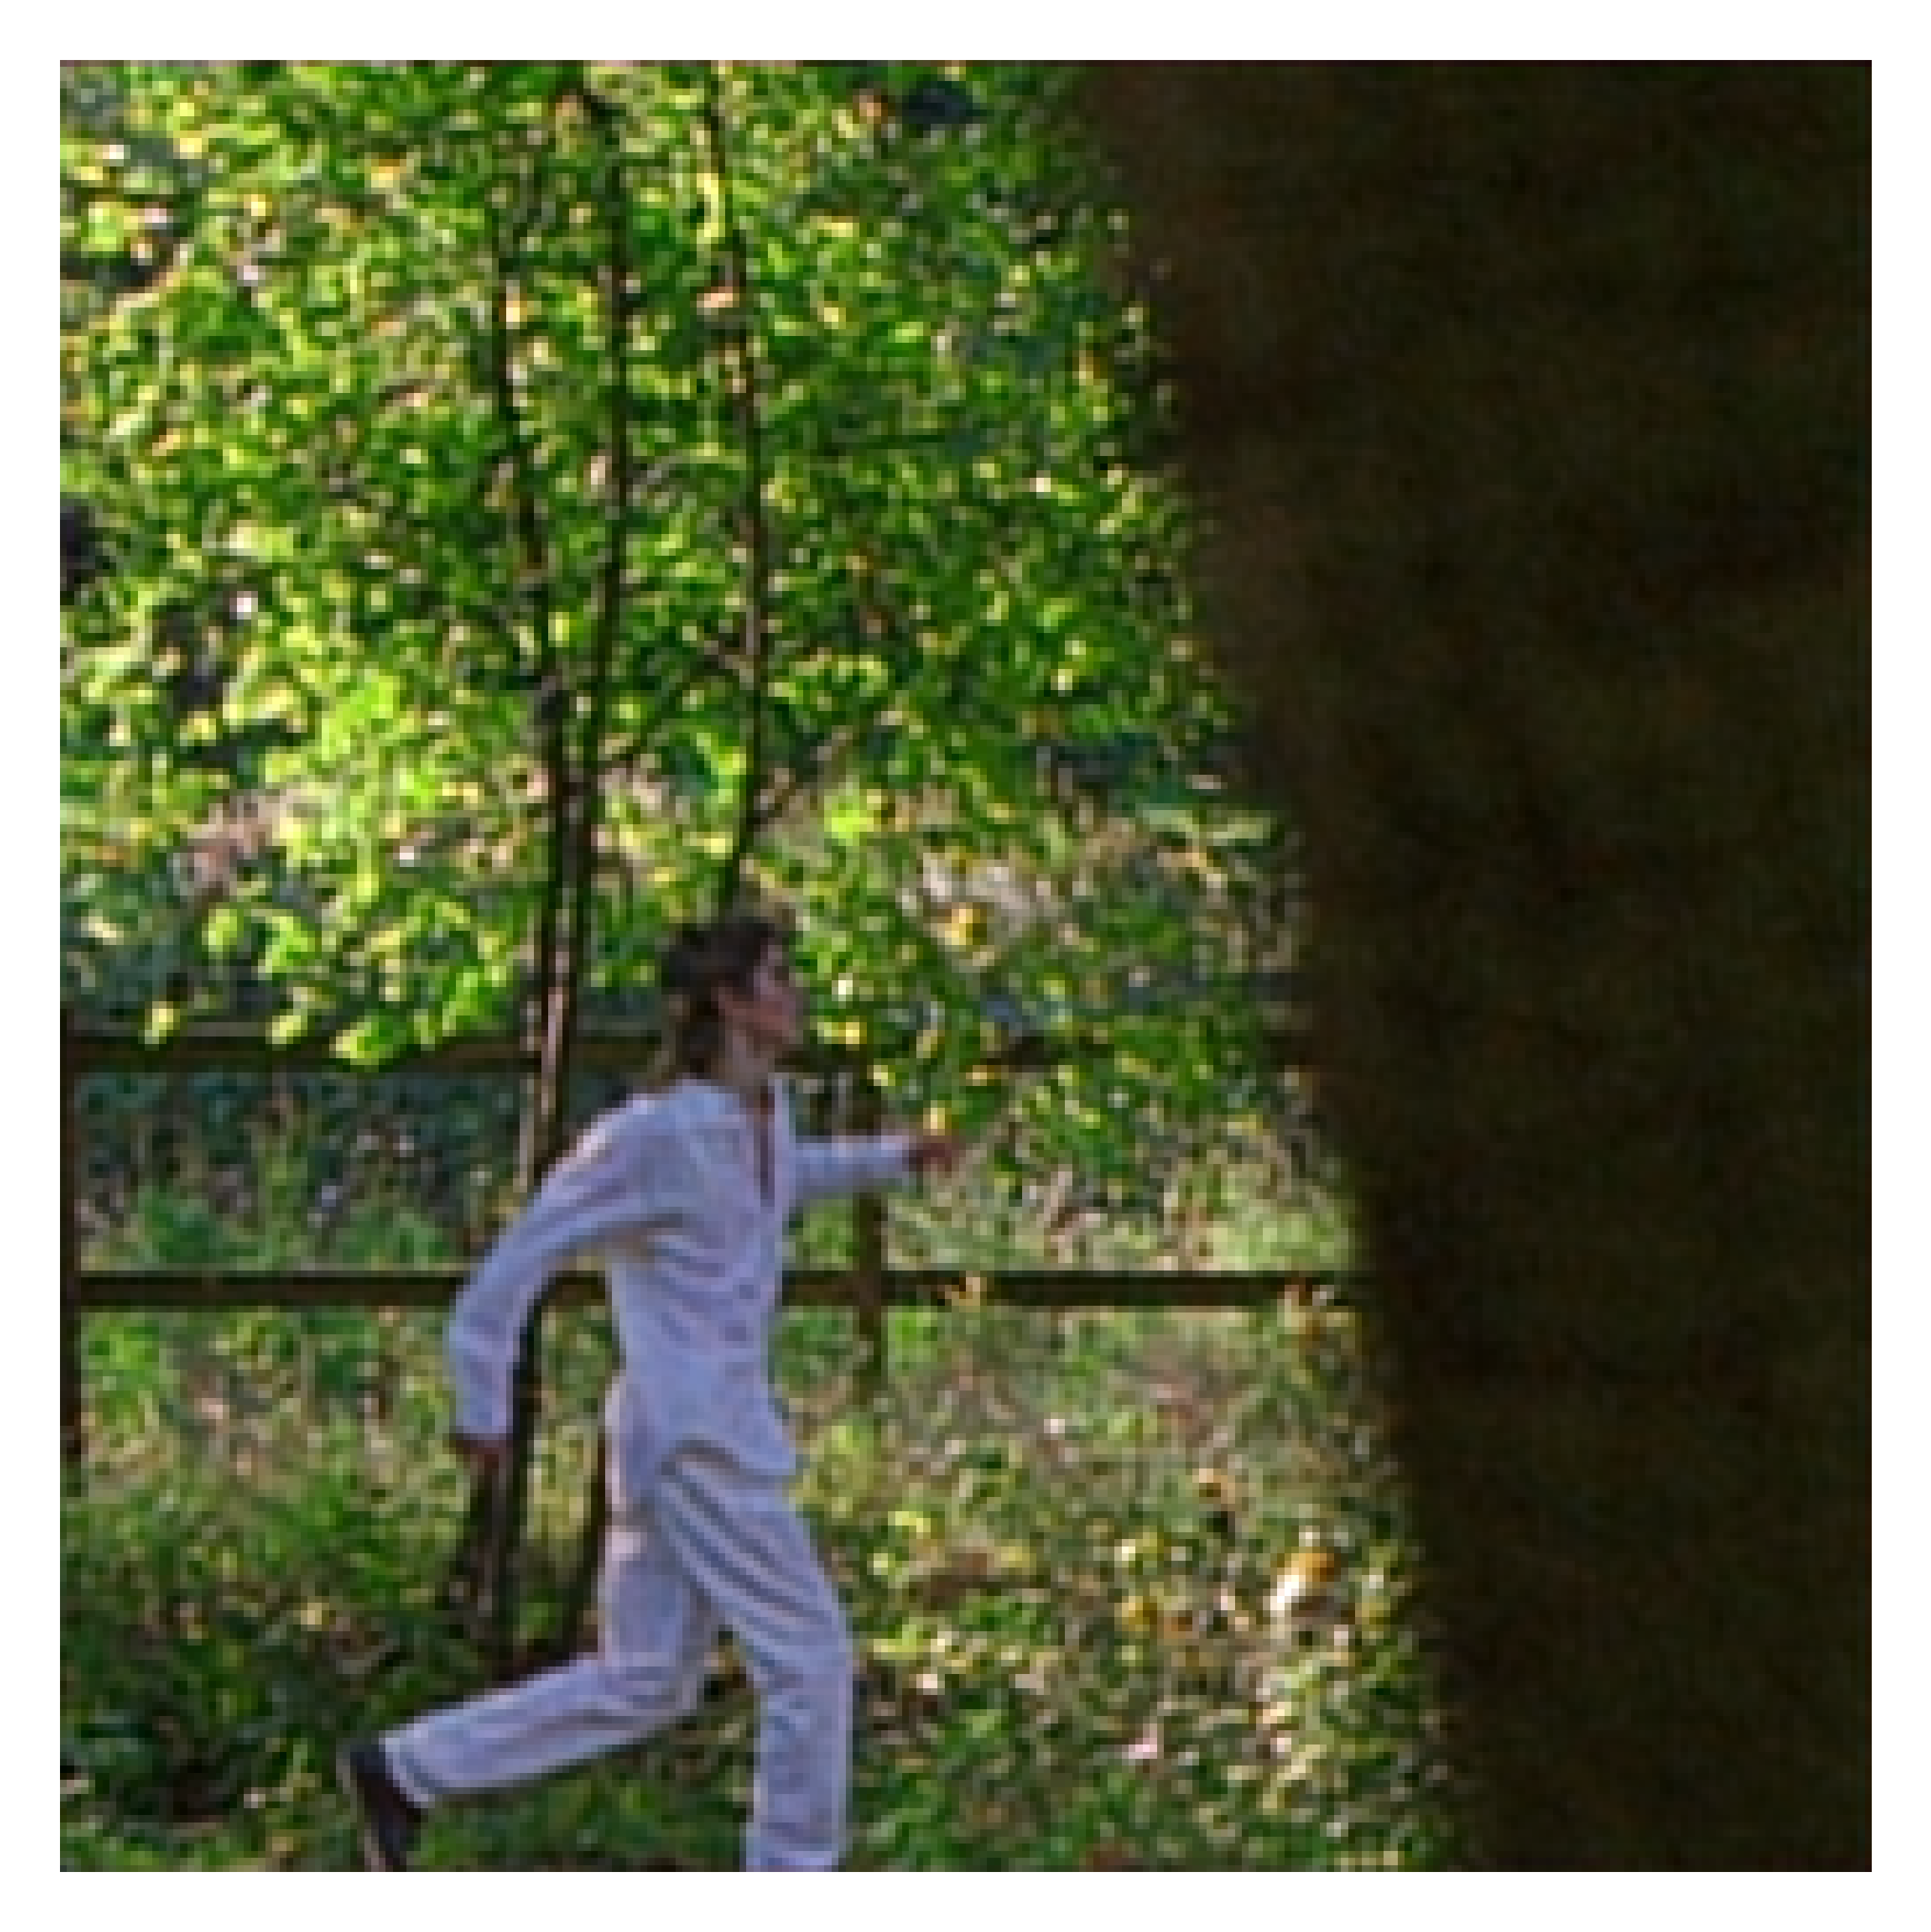

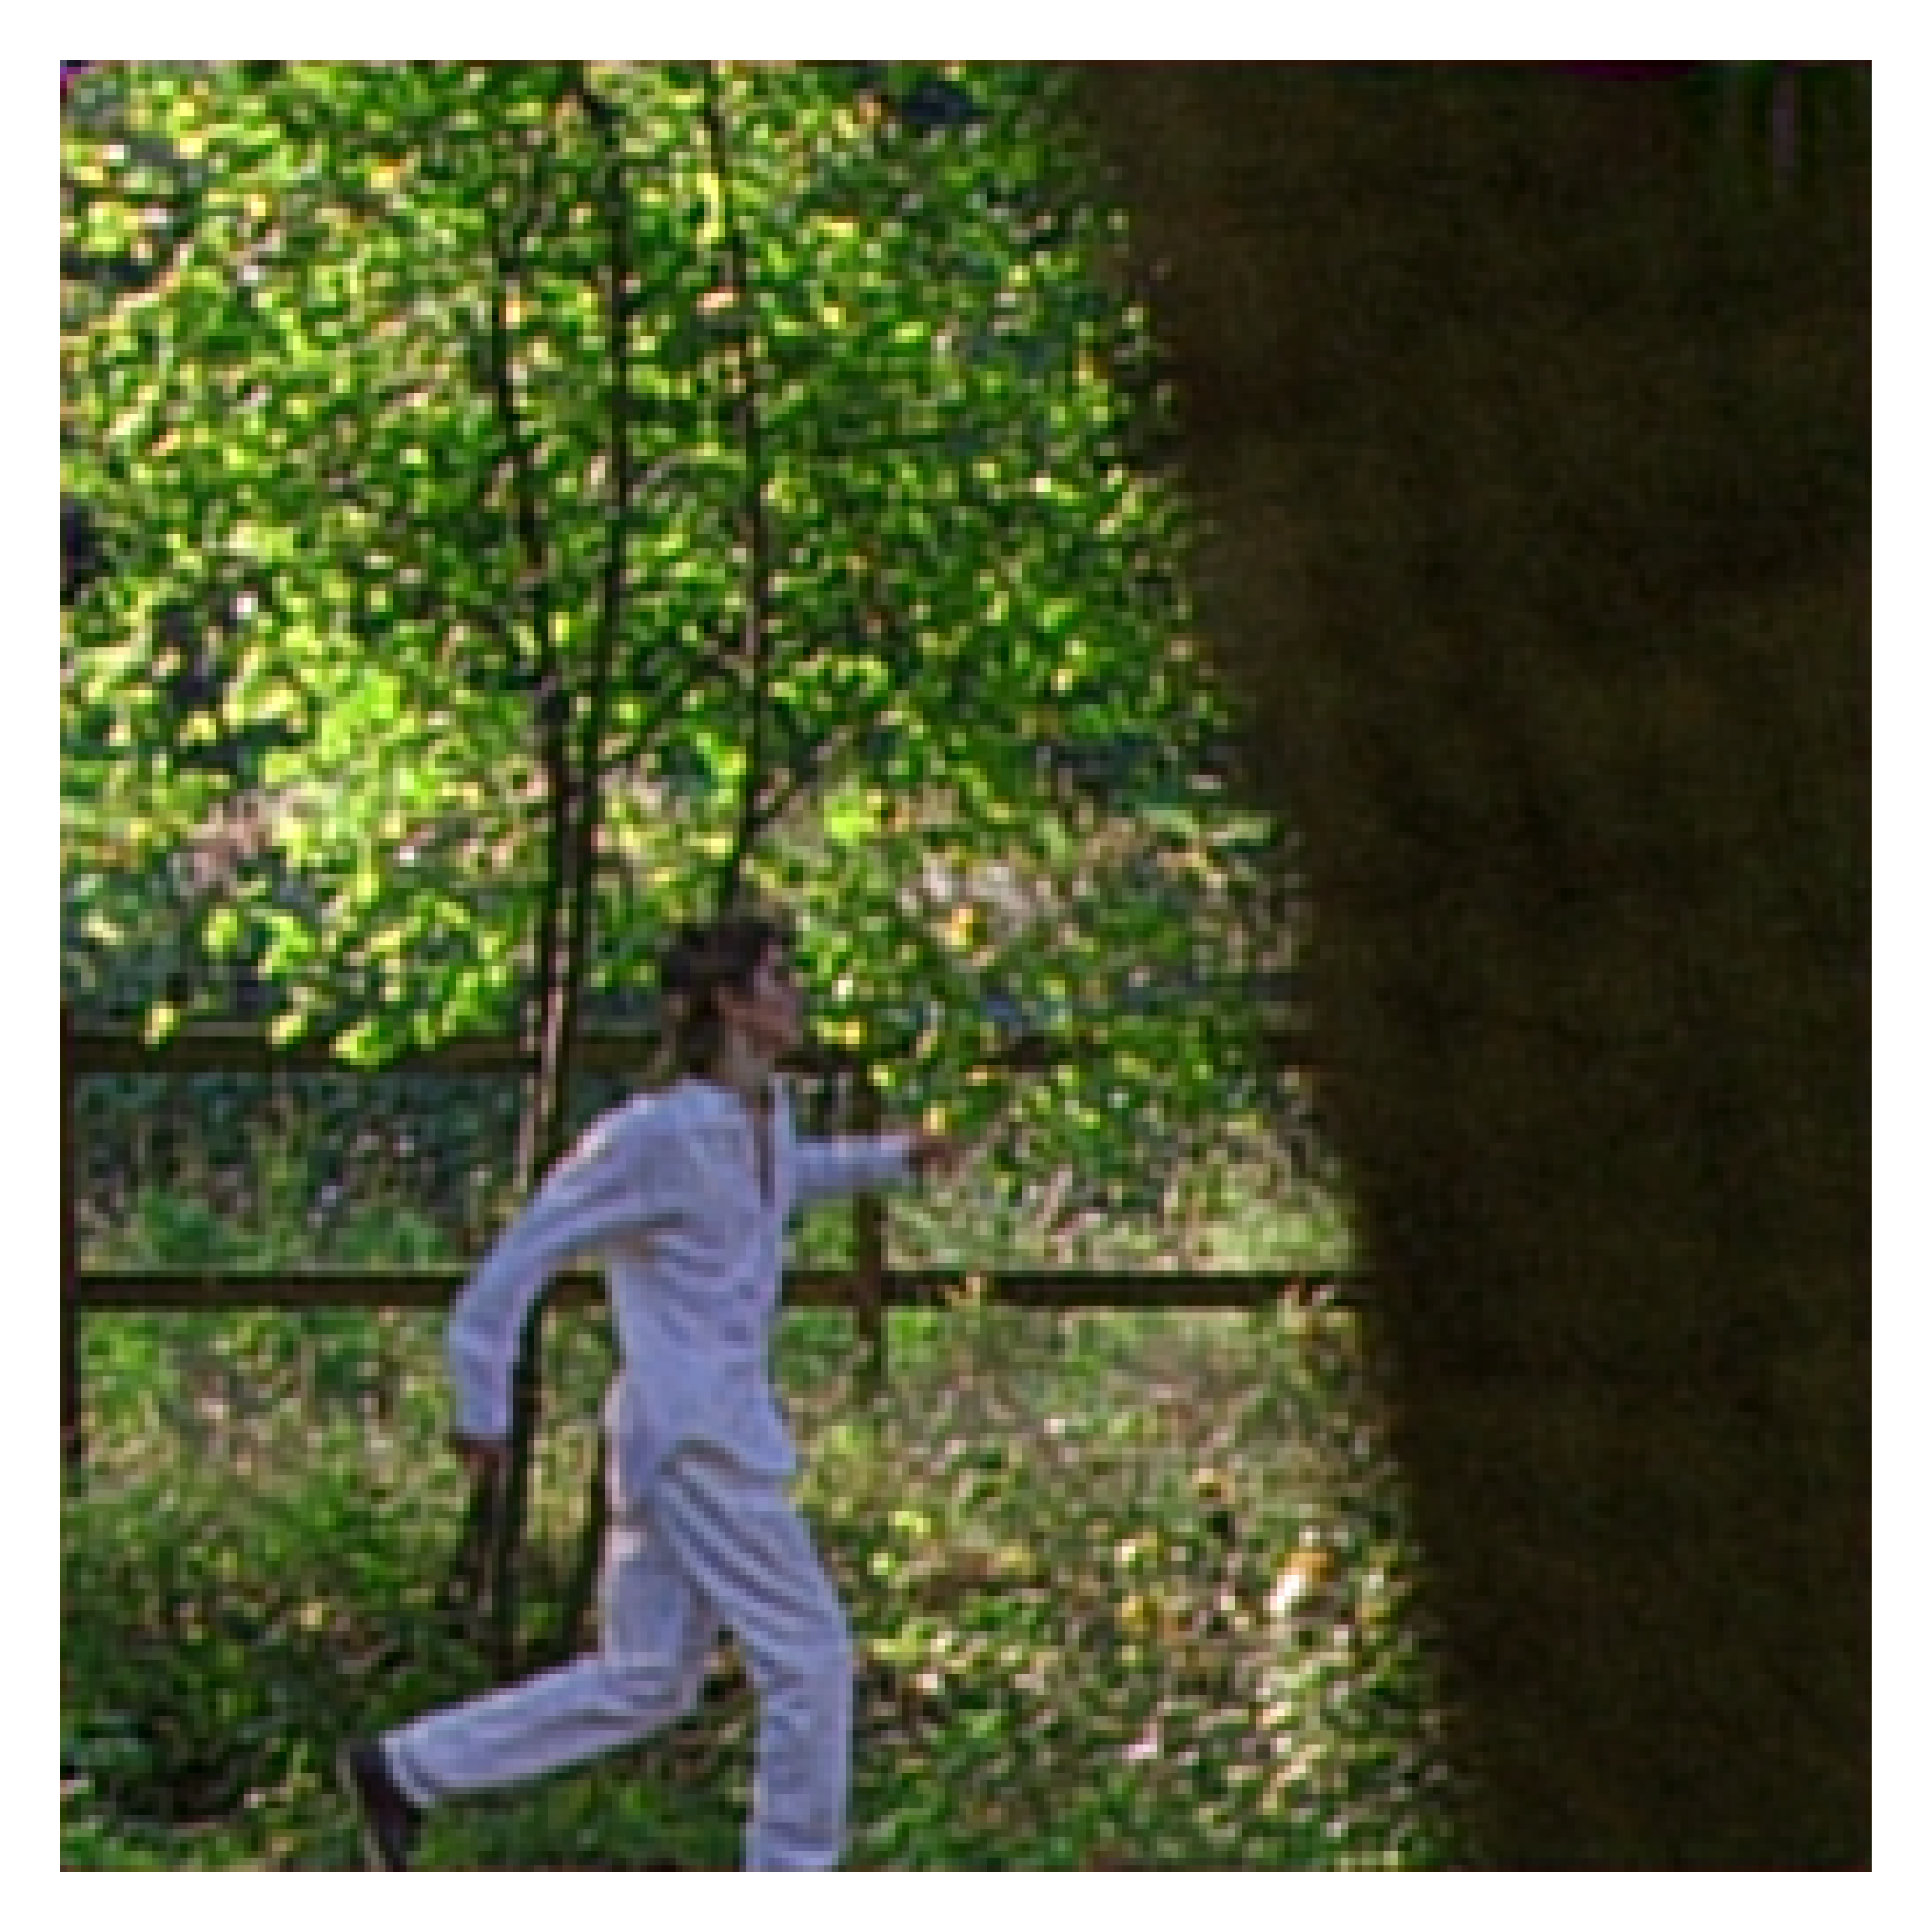

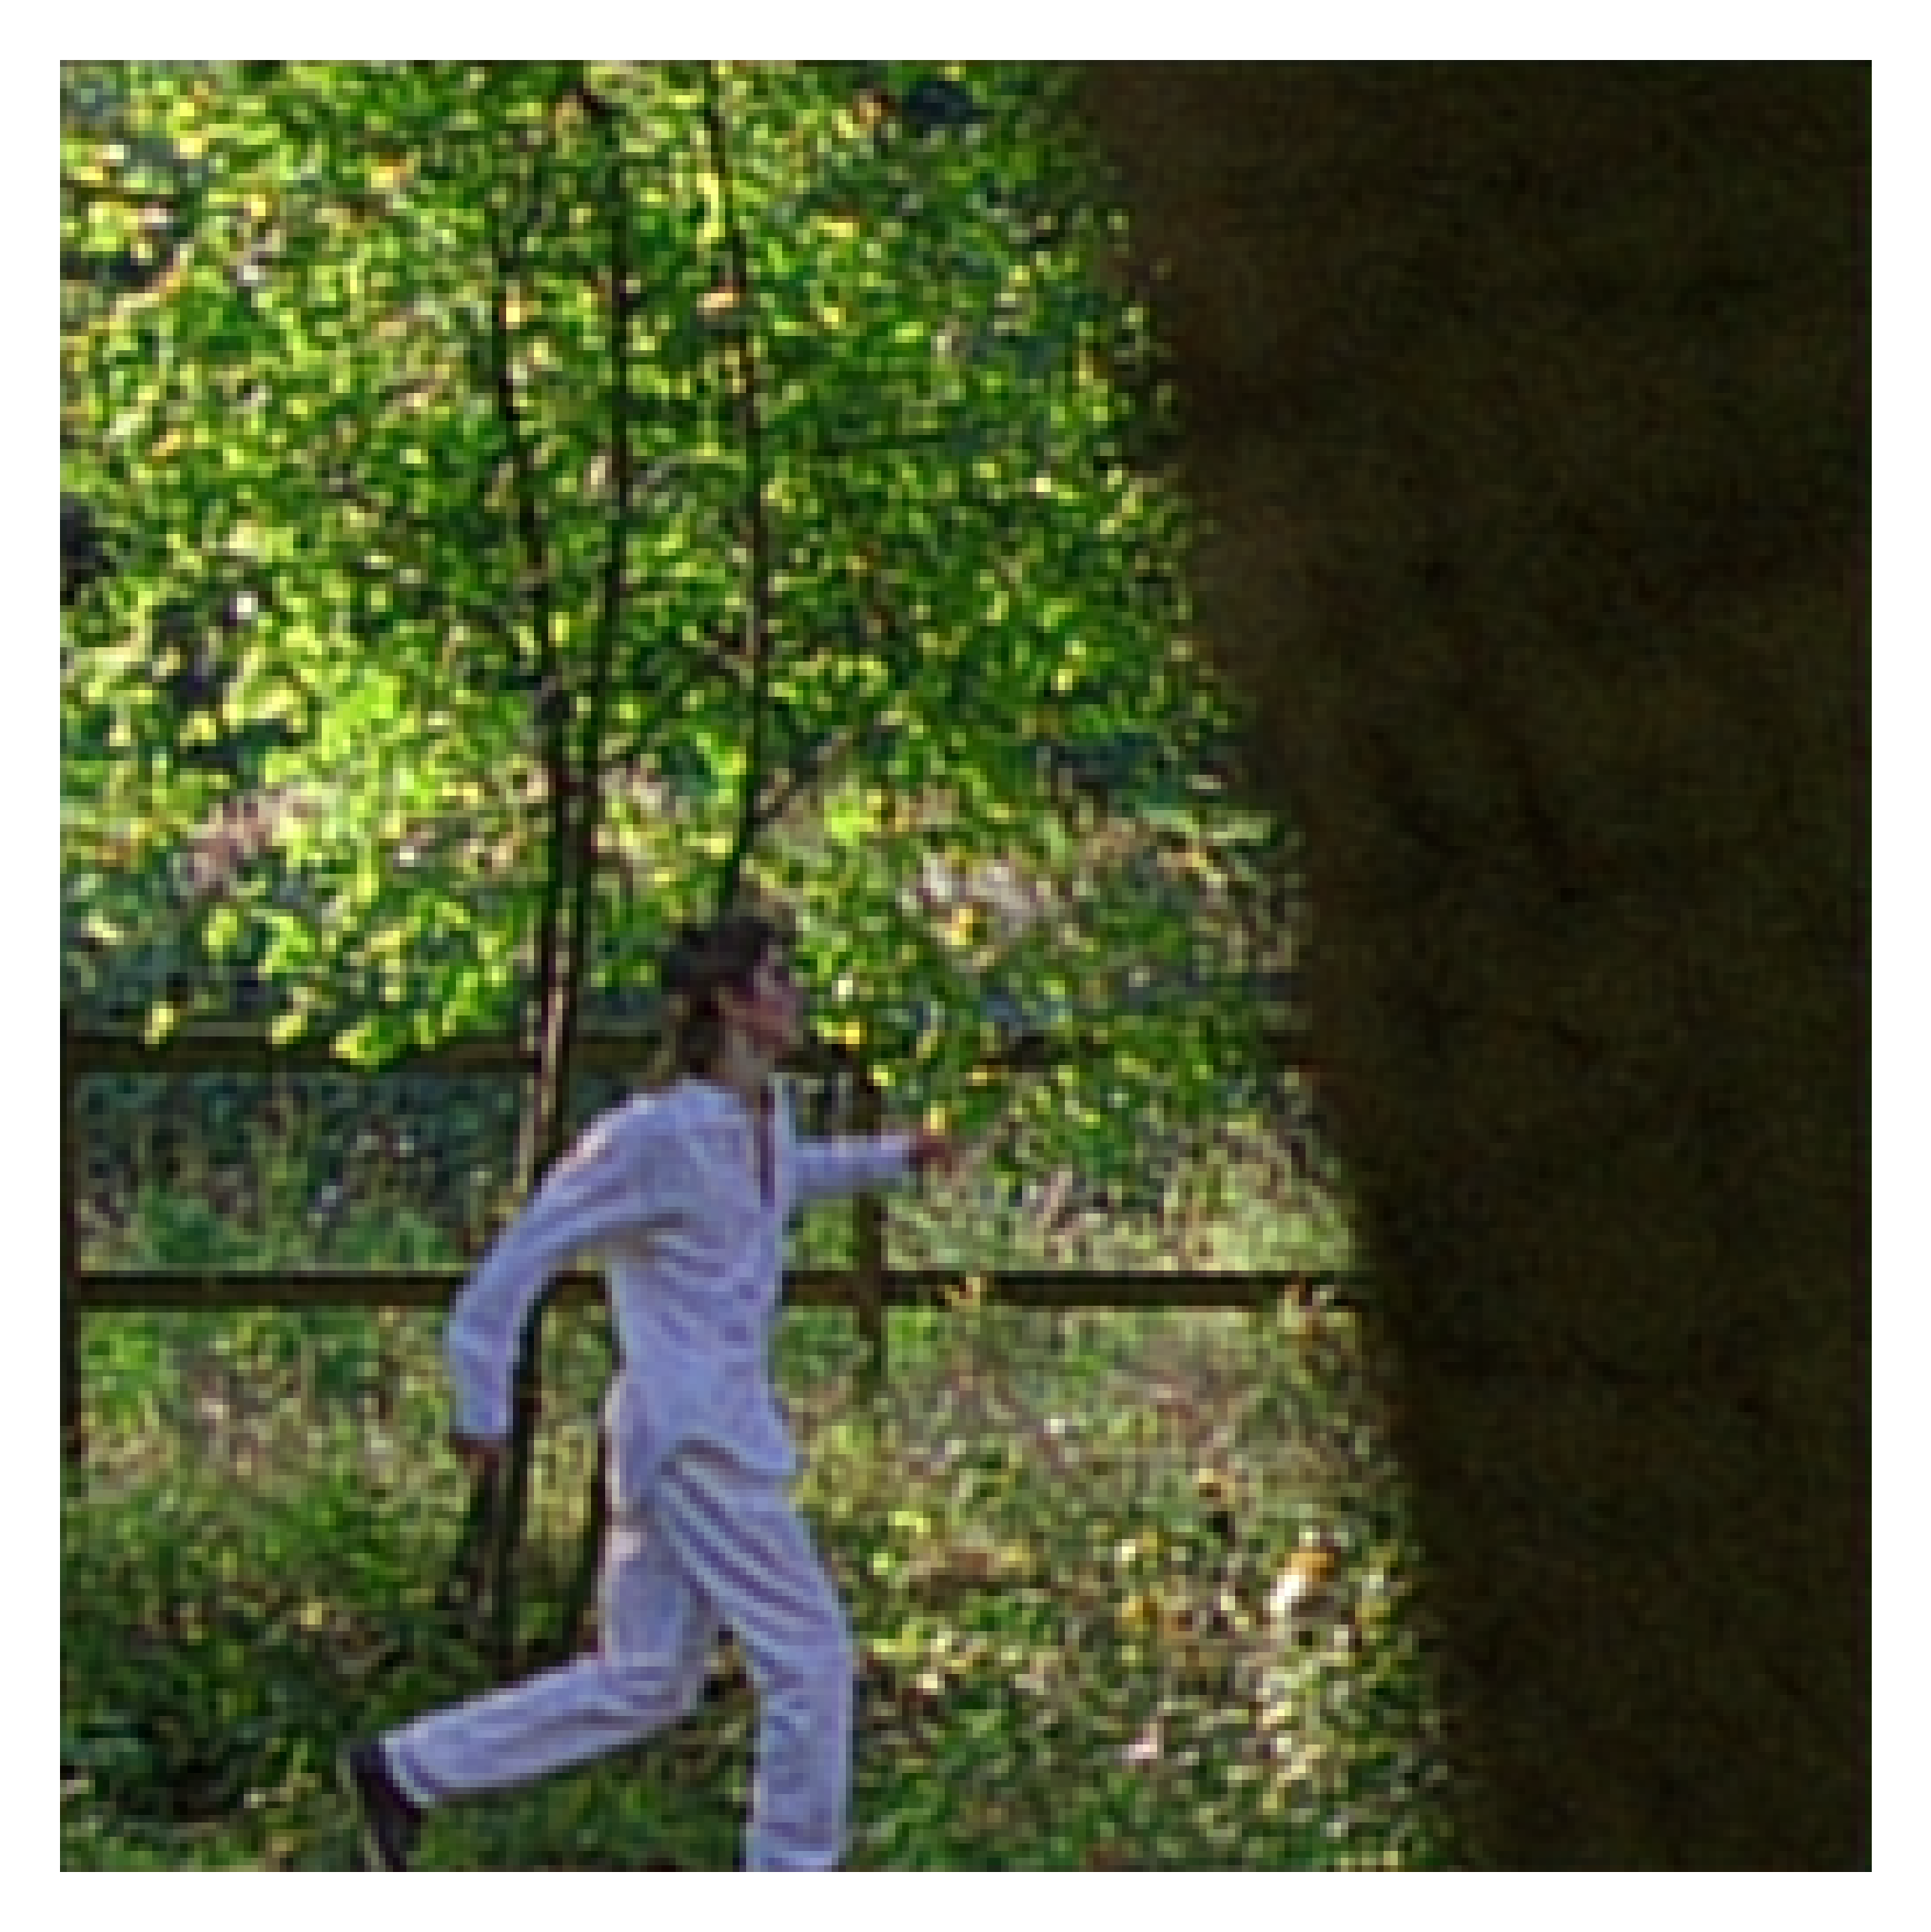

In [181]:
#patches_show
model_dirs_full, model_target_met_names, model_names = get_met_names(key= lambda x: "2000mse" in x and 
                                                                     "cheng2020_attn_quality2" in x and 
                                                                     'quality5' not in x and (('fixed_direction' in x) or 
                                                                                              "MDTVSFA_2000m" in x))
net_enhances = load_models(model_dirs_full)
ful_name = os.path.join(dst_dir, sorted(os.listdir(dst_dir))[4])
dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 5, minimal_batch_sz = 2)
dataset_test = DataLoader(dataset_test, batch_size = 2, shuffle = False)    
Y = next(iter(dataset_test))
loss_calc = None
Y = torchvision.transforms.CenterCrop((256,256))(Y)
Y = Y.to(device)
Log_1 = {"X":[], "vals": []}
for model,met_name,fil_name_1 in tqdm(zip(net_enhances, model_target_met_names, model_names)):
    print(fil_name_1)
    with torch.no_grad():
        model = model.to(device)
        del loss_calc
        loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"SSIM", met_name], k_lst=[0, 0.0, -1.])
        loss_calc = loss_calc.to(device)
        X_out_img = model(Y)
        X_out = {"x_hat" : X_out_img}
        val = loss_calc(X_out, Y)
        Log_1["vals"].append([val["PSNR"].mean().item(), val["SSIM"].mean().item(), val[met_name].mean().item()])
        Log_1["X"].append(X_out_img.cpu().numpy())
        pltimshow_batch([X_out_img[0].unsqueeze(0)], filename='vis/patches/' + met_name + 'pedestrian_area.png')
np.save("vis/patches/log1_pedestrian_area.npy", Log_1)

In [4]:



#from Current_model import *
loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"MDTVSFA", "VSFA", "PAC2PIC","SPAQ", "Linearity", "SSIM"], k_lst=[2000.0, 1.],)
Lst1 = ["./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt", 
"./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_no_codec.ckpt",
"./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_quality5.ckpt"]
#Lst1 = [Lst1[0]]
#Lst1 = [Lst1[0], Lst1[4], Lst1[5], Lst1[8], Lst1[-1]]
Lst2 = list(map(lambda x : x.split("_")[3], Lst1))
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
batch_sz = 2
net_enhances = load_models(Lst1) + [Identity_preproc]

loss_calc = None
Log_1 = []
Log_2 = []
for file in tqdm(os.listdir(dst_dir)):
    Log_2 = []
    for model,met_name,fil_name_1 in tqdm(zip(net_enhances, Lst2, Lst1)):
        with torch.no_grad():
            try:
                print(fil_name_1)
                del loss_calc
                loss_calc = Custom_enh_Loss(target_lst=['mse_loss', met_name])
                ful_name = dst_dir + file
                home_dir = "R:/home_dir/"
                #dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 64, minimal_batch_sz = 2)#
                #dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
                Log_3 = models_codecs_dataset_outer([model],codecs = [" -vcodec libx264   -preset:v medium -b:v 200k ",
                                                                      " -vcodec libx264   -preset:v medium -b:v 1M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 2M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 3M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 4M "
                                                          " -vcodec libx264   -preset:v medium -b:v 7M "],
                                    vid_full_dir = ful_name, to_crop = False, loss_f = loss_calc)
                print(Log_3)
                Log_2.append(Log_3)
            except Exception:
                raise
    Log_1.append(Log_2)
    np.save("./Logs_rd_curves/FullHD_7videos_64frames_MDTVSFA.npy", Log_1)
print(Log_1)

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt


0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\envs\backup\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0023574429, 0.0005976984, 0.00046689765, 0.0004930806, 0.0004034749], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.5437276, 0.3994539, 0.31440073, 0.33142617, 0.2731601], 'PSNR': [26.34096, 32.330116, 33.422638, 33.353107, 34.22544], 'MDTVSFA': [-0.46776208, -0.5433455, -0.5572795, -0.56102777, -0.5621933], 'loss': [-935.52185, -1086.6904, -1114.5586, -1122.0549, -1124.3861], 'bitrate': [0.210112, 0.916081, 2.330806, 5.243768, 20.533087]}]
./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_no_codec.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021362235, 0.00051131507, 0.00031416694, 0.000255903, 0.00020909187], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.3998799, 0.34328318, 0.2150876, 0.17720148, 0.14676253], 'PSNR': [26.784931, 32.986168, 35.08304, 35.967857, 37.013184], 'MDTVSFA': [-0.4721684, -0.5241114, -0.5374199, -0.5429396, -0.5487151], 'loss': [-944.33466, -1048.2224, -1074.8395, -1085.879, -1097.4299], 'bitrate': [0.220075, 0.874681, 1.733337, 2.741825, 10.56635]}]
./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_quality5.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0023043612, 0.0005997765, 0.00041157613, 0.00037465506, 0.0003459356], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.5092115, 0.40080518, 0.27842793, 0.25441998, 0.23574516], 'PSNR': [26.439861, 32.28099, 33.904488, 34.32704, 34.826973], 'MDTVSFA': [-0.47146785, -0.5293166, -0.54810405, -0.5573543, -0.56709695], 'loss': [-942.93335, -1058.6327, -1096.2076, -1114.7081, -1134.1936], 'bitrate': [0.212843, 0.864956, 1.845025, 3.418862, 15.93385]}]


0it [00:00, ?it/s]

./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00520561, 0.001290064, 0.0008633974, 0.00065807014, 0.00034358486], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.3957481, 0.8496647, 0.5722246, 0.4387107, 0.23421662], 'PSNR': [23.808516, 29.7324, 31.858852, 33.142334, 35.435738], 'MDTVSFA': [-0.4305562, -0.47461945, -0.4933626, -0.50523496, -0.52155757], 'loss': [-861.1072, -949.2376, -986.7243, -1010.4693, -1043.115], 'bitrate': [0.527268, 1.920131, 4.285006, 6.7282, 15.913637]}]
./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_no_codec.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0038207634, 0.0010353667, 0.0005916643, 0.00041636813, 0.00016650645], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [2.4952521, 0.6840477, 0.39553022, 0.28154394, 0.11907136], 'PSNR': [24.762451, 30.60218, 33.145508, 34.727142, 38.531357], 'MDTVSFA': [-0.4328375, -0.47255683, -0.48349518, -0.49104923, -0.49858186], 'loss': [-865.67114, -945.1126, -966.9898, -982.0981, -997.1636], 'bitrate': [0.585543, 1.985225, 3.99435, 5.954981, 12.918487]}]
./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_quality5.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0043938123, 0.0011374191, 0.00070363074, 0.00053401943, 0.00028284418], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [2.8678768, 0.75040734, 0.4683364, 0.3580467, 0.19471997], 'PSNR': [24.16763, 30.132164, 32.383026, 33.68212, 36.273155], 'MDTVSFA': [-0.42939118, -0.47232747, -0.48808253, -0.5014486, -0.5210449], 'loss': [-858.77795, -944.6538, -976.1644, -1002.8966, -1042.0895], 'bitrate': [0.533806, 1.869025, 3.881106, 6.022493, 14.30115]}]


0it [00:00, ?it/s]

./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0030773757, 0.00038966295, 0.00023430696, 0.00020208245, 0.00016689308], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [2.011864, 0.26417887, 0.16315864, 0.14220466, 0.11932277], 'PSNR': [26.329258, 35.071243, 37.18471, 37.800957, 38.34836], 'MDTVSFA': [-0.38786092, -0.45270482, -0.47529674, -0.48864216, -0.5147636], 'loss': [-775.71875, -905.40924, -950.5932, -977.2842, -1029.5271], 'bitrate': [0.304318, 1.145237, 2.355431, 3.872625, 11.534275]}]
./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_no_codec.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0026516155, 0.0003429675, 0.00018955929, 0.00014732931, 0.00010256689], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.7350135, 0.23381516, 0.13406146, 0.106601425, 0.077494666], 'PSNR': [27.164087, 35.456974, 37.741737, 38.70752, 40.11524], 'MDTVSFA': [-0.3913133, -0.44620097, -0.46101516, -0.4696585, -0.48990655], 'loss': [-782.624, -892.40155, -922.03015, -939.31683, -979.813], 'bitrate': [0.352256, 1.237318, 2.334475, 3.493706, 9.292037]}]
./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_quality5.ckpt


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [5]:



#from Current_model import *
loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"MDTVSFA", "VSFA", "PAC2PIC","SPAQ", "Linearity", "SSIM"], k_lst=[2000.0, 1.],)
Lst1 = ["./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt", 
"./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_no_codec.ckpt",
"./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_quality5.ckpt"]
Lst1 = [Lst1[0]]
#Lst1 = [Lst1[0], Lst1[4], Lst1[5], Lst1[8], Lst1[-1]]
Lst2 = list(map(lambda x : x.split("_")[3], Lst1))
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
batch_sz = 2
net_enhances = load_models(Lst1) + [Identity_preproc]

loss_calc = None
Log_1 = []
Log_2 = []
for file in tqdm(os.listdir(dst_dir)):
    Log_2 = []
    for model,met_name,fil_name_1 in tqdm(zip(net_enhances, Lst2, Lst1)):
        with torch.no_grad():
            try:
                print(fil_name_1)
                del loss_calc
                loss_calc = Custom_enh_Loss(target_lst=['mse_loss', met_name])
                ful_name = dst_dir + file
                home_dir = "R:/home_dir/"
                #dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 64, minimal_batch_sz = 2)#
                #dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
                Log_3 = models_codecs_dataset_outer([Identity_preproc],codecs = [" -vcodec libx264   -preset:v medium -b:v 200k ",
                                                                      " -vcodec libx264   -preset:v medium -b:v 1M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 2M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 3M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 4M "
                                                          " -vcodec libx264   -preset:v medium -b:v 7M "],
                                    vid_full_dir = ful_name, to_crop = False, loss_f = loss_calc)
                print(Log_3)
                Log_2.append(Log_3)
            except Exception:
                raise
    Log_1.append(Log_2)
    np.save("./Logs_rd_curves/FullHD_7videos_64frames_MDTVSFA_Identity.npy", Log_1)
print(Log_1)

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021202986, 0.0004927205, 0.0002965477, 0.00023913698, 0.00019198182], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.3895247, 0.33119205, 0.20363069, 0.16629937, 0.13563672], 'PSNR': [26.818054, 33.148396, 35.33579, 36.270115, 37.447083], 'MDTVSFA': [-0.47728467, -0.5207389, -0.53338027, -0.53593826, -0.5392315], 'loss': [-954.56714, -1041.4773, -1066.7601, -1071.8762, -1078.4626], 'bitrate': [0.219825, 0.872675, 1.732375, 2.7406, 10.6279]}]


0it [00:00, ?it/s]

./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [4]:

#from Current_model import *
loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"MDTVSFA", "VSFA", "PAC2PIC","SPAQ", "Linearity", "SSIM"], k_lst=[2000.0, 1.],)
Lst1 = sorted(["./models_enhancement/" + i for i in os.listdir("./models_enhancement/") if "fixed_direction" in i])
#Lst1 = [Lst1[0], Lst1[4], Lst1[5], Lst1[8], Lst1[-1]]
Lst2 = list(map(lambda x : x.split("_")[3], Lst1))
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
batch_sz = 2
net_enhances = load_models(Lst1) + [Identity_preproc]

loss_calc = None
Log_1 = []
Log_2 = []
for file in tqdm(os.listdir(dst_dir)):
    Log_2 = []
    for model,met_name,fil_name_1 in tqdm(zip(net_enhances, Lst2, Lst1)):
        with torch.no_grad():
            try:
                print(fil_name_1)
                del loss_calc
                loss_calc = Custom_enh_Loss(target_lst=['mse_loss', met_name])
                ful_name = dst_dir + file
                home_dir = "R:/home_dir/"
                #dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 64, minimal_batch_sz = 2)#
                #dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
                Log_3 = models_codecs_dataset_outer([model],codecs = [" -vcodec libx264   -preset:v medium -b:v 200k ",
                                                                      " -vcodec libx264   -preset:v medium -b:v 1M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 2M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 3M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 4M "
                                                          " -vcodec libx264   -preset:v medium -b:v 7M "],
                                    vid_full_dir = ful_name, to_crop = False, loss_f = loss_calc)
                print(Log_3)
                Log_2.append(Log_3)
            except Exception:
                raise
    Log_1.append(Log_2)
    np.save("./Logs_rd_curves/patches_FullHD_7videos_32frames.npy", Log_1)
print(Log_1)

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

./models_enhancement/model_vimeo11k_Linearity_2000mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\envs\backup\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002355516, 0.00058838807, 0.0004326819, 0.00043636747, 0.00037817817], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.5424749, 0.39339986, 0.29215196, 0.29454848, 0.2567109], 'PSNR': [26.340862, 32.383743, 33.719337, 33.79398, 34.512398], 'Linearity': [-0.573918, -0.57406944, -0.5739159, -0.5738998, -0.5739151], 'loss': [-1147.8336, -1148.1382, -1147.8314, -1147.7991, -1147.8298], 'bitrate': [0.2119, 0.888506, 2.078731, 4.559262, 19.178225]}]
./models_enhancement/model_vimeo11k_Linearity_2000mse_enhance_no_codec_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021575652, 0.0005069759, 0.000314537, 0.0002546233, 0.00020545829], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.4137574, 0.34046164, 0.21532822, 0.17636934, 0.14439979], 'PSNR': [26.75978, 33.02118, 35.077072, 35.989418, 37.075195], 'Linearity': [-0.5738926, -0.5739155, -0.5739155, -0.57391405, -0.57390445], 'loss': [-1147.7831, -1147.8303, -1147.8306, -1147.8279, -1147.8088], 'bitrate': [0.2204, 0.873868, 1.737812, 2.743356, 10.281043]}]
./models_enhancement/model_vimeo11k_Linearity_200mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0022823366, 0.0005743505, 0.00039945653, 0.0003727118, 0.00033554473], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.49489, 0.38427198, 0.27054715, 0.2531564, 0.2289885], 'PSNR': [26.49295, 32.491055, 34.05093, 34.393448, 35.05052], 'Linearity': [-0.5739155, -0.5739157, -0.5739155, -0.5739124, -0.5739155], 'loss': [-1147.8286, -1147.8308, -1147.8306, -1147.8243, -1147.8306], 'bitrate': [0.214287, 0.895325, 1.920281, 3.61745, 16.4347]}]
./models_enhancement/model_vimeo11k_Linearity_20mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002283719, 0.0006133559, 0.00041178832, 0.00035527223, 0.00030936868], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.4957888, 0.4096352, 0.27856588, 0.24181631, 0.21196753], 'PSNR': [26.485062, 32.176914, 33.88891, 34.52488, 35.200768], 'Linearity': [-0.5739161, -0.57391536, -0.5739155, -0.5739155, -0.57379735], 'loss': [-1147.8298, -1147.8302, -1147.8306, -1147.8306, -1147.5944], 'bitrate': [0.219393, 0.882793, 1.780987, 2.872587, 11.077568]}]
./models_enhancement/model_vimeo11k_NIMA_20mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\envs\backup\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0023727757, 0.0005878081, 0.0004342958, 0.0004435858, 0.00038253903], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.5536981, 0.39302278, 0.2932014, 0.2992422, 0.25954655], 'PSNR': [26.317263, 32.39572, 33.70793, 33.750412, 34.474262], 'NIMA': [-0.099999994, -0.1, -0.1, -0.1, -0.099999994], 'loss': [-199.99762, -199.9994, -199.99957, -199.99954, -199.99962], 'bitrate': [0.210262, 0.892862, 2.123456, 4.695993, 19.697]}]
./models_enhancement/model_vimeo11k_PAC2PIC_2000mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002410478, 0.00060125825, 0.00046196874, 0.0004736227, 0.00040605845], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.5782139, 0.40176874, 0.3111957, 0.31877372, 0.27484003], 'PSNR': [26.244522, 32.291447, 33.43695, 33.427895, 34.13394], 'PAC2PIC': [-0.5815685, -0.7208467, -0.7352854, -0.73611724, -0.74655294], 'loss': [-1163.1345, -1441.6929, -1470.5703, -1472.234, -1493.1055], 'bitrate': [0.21115, 0.916731, 2.235612, 4.836706, 19.528856]}]
./models_enhancement/model_vimeo11k_PAC2PIC_2000mse_enhance_no_codec_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002172355, 0.0005490704, 0.00035582721, 0.00030072313, 0.0002522939], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.4233744, 0.36783358, 0.24217719, 0.20634577, 0.17485464], 'PSNR': [26.712006, 32.673897, 34.534042, 35.25833, 36.08984], 'PAC2PIC': [-0.58359087, -0.70943415, -0.7335352, -0.73900825, -0.74985504], 'loss': [-1167.1796, -1418.8677, -1467.07, -1478.0161, -1499.7097], 'bitrate': [0.221875, 0.887993, 1.833093, 3.003818, 11.088287]}]
./models_enhancement/model_vimeo11k_PAC2PIC_20mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.18383732, 0.18382707, 0.18382695, 0.18383044, 0.18383029], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [119.55103, 119.54436, 119.54428, 119.54654, 119.54645], 'PSNR': [7.3557916, 7.356032, 7.3560343, 7.3559523, 7.355956], 'PAC2PIC': [-0.50405145, -0.50170815, -0.5014788, -0.5012702, -0.5012498], 'loss': [-1007.91907, -1003.23254, -1002.7738, -1002.3565, -1002.3157], 'bitrate': [0.03105, 0.129625, 0.23875, 0.300081, 0.43155]}]
./models_enhancement/model_vimeo11k_SPAQ_2000mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0023483979, 0.00057953957, 0.00041468925, 0.00041517534, 0.00035896612], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.5378463, 0.38764617, 0.28045225, 0.2807683, 0.24421826], 'PSNR': [26.358662, 32.45478, 33.90307, 34.00193, 34.756058], 'SPAQ': [-0.42001796, -0.47714764, -0.47790223, -0.47160983, -0.47769955], 'loss': [-840.03357, -954.2947, -955.8041, -943.21924, -955.39874], 'bitrate': [0.211087, 0.885356, 2.048693, 4.390837, 18.355625]}]
./models_enhancement/model_vimeo11k_SPAQ_2000mse_enhance_no_codec_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021003394, 0.00051744876, 0.0003235344, 0.00026415888, 0.00021494471], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.3765461, 0.34727162, 0.22117877, 0.18256985, 0.15056835], 'PSNR': [26.851692, 32.92954, 34.95189, 35.82811, 36.87055], 'SPAQ': [-0.42086887, -0.44869673, -0.4546957, -0.47124374, -0.48273158], 'loss': [-841.73566, -897.39294, -909.391, -942.48724, -965.463], 'bitrate': [0.218987, 0.873387, 1.7376, 2.750287, 10.423206]}]
./models_enhancement/model_vimeo11k_SPAQ_20mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0026309616, 0.0012416063, 0.0013500324, 0.0013378843, 0.001224009], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.7215834, 0.81815505, 0.88865906, 0.8807599, 0.8067124], 'PSNR': [25.853155, 29.10442, 28.760437, 28.783743, 29.129309], 'SPAQ': [-0.48272967, -0.5310549, -0.55224717, -0.5534233, -0.5545162], 'loss': [-965.4567, -1062.1086, -1104.4929, -1106.8453, -1109.0312], 'bitrate': [0.208231, 1.234893, 4.150093, 8.015162, 22.821575]}]
./models_enhancement/model_vimeo11k_VSFA_2000mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0024309428, 0.00064352073, 0.0005158535, 0.00054901897, 0.00045873463], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.5915211, 0.42924994, 0.34623426, 0.36780012, 0.30909273], 'PSNR': [26.20663, 32.004684, 32.972336, 32.845993, 33.578735], 'VSFA': [-0.44770786, -0.53969765, -0.5616209, -0.5668886, -0.57134163], 'loss': [-895.41327, -1079.3945, -1123.2412, -1133.7766, -1142.6827], 'bitrate': [0.209475, 0.914912, 2.377662, 5.599356, 21.135962]}]
./models_enhancement/model_vimeo11k_VSFA_2000mse_enhance_no_codec_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002156932, 0.0005226748, 0.00033754122, 0.00028947496, 0.00024250388], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.4133456, 0.35066983, 0.23028672, 0.19903165, 0.1684887], 'PSNR': [26.74639, 32.89038, 34.766384, 35.428764, 36.28154], 'VSFA': [-0.45403117, -0.52289456, -0.54442036, -0.566406, -0.61371434], 'loss': [-908.0601, -1045.7886, -1088.8406, -1132.8118, -1227.4285], 'bitrate': [0.220543, 0.881181, 1.826137, 3.014037, 11.32395]}]
./models_enhancement/model_vimeo11k_VSFA_20mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.18387593, 0.18386781, 0.18386793, 0.18386789, 0.18386817], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [119.576126, 119.57085, 119.57093, 119.57089, 119.57109], 'PSNR': [7.3548775, 7.355069, 7.3550663, 7.3550677, 7.3550606], 'VSFA': [-0.3309524, -0.33108348, -0.3311995, -0.33117348, -0.3312509], 'loss': [-661.7209, -661.9831, -662.2151, -662.16315, -662.3179], 'bitrate': [0.021412, 0.055693, 0.083918, 0.094381, 0.121812]}]


0it [00:00, ?it/s]

./models_enhancement/model_vimeo11k_Linearity_2000mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.004641761, 0.0012538398, 0.0007919079, 0.00058994786, 0.00030073553], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.0291057, 0.8261099, 0.5257386, 0.39441413, 0.20635384], 'PSNR': [24.055302, 29.85244, 32.113487, 33.47703, 35.96897], 'Linearity': [-0.573915, -0.5739155, -0.5739167, -0.5738716, -0.5739155], 'loss': [-1147.8252, -1147.8297, -1147.8325, -1147.7427, -1147.8306], 'bitrate': [0.544781, 1.945112, 4.177518, 6.42325, 15.031981]}]
./models_enhancement/model_vimeo11k_Linearity_2000mse_enhance_no_codec_fixed_direction.ckpt


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [7]:

#from Current_model import *
loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"MDTVSFA", "VSFA", "PAC2PIC","SPAQ", "Linearity", "SSIM"], k_lst=[2000.0, 1.],)
Lst1 = sorted(["./models_enhancement/" + i for i in os.listdir("./models_enhancement/") if "fixed_direction" in i])
#Lst1 = [Lst1[0], Lst1[4], Lst1[5], Lst1[8], Lst1[-1]]
Lst2 = list(map(lambda x : x.split("_")[3], Lst1))
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
batch_sz = 2
net_enhances = load_models(Lst1) + [Identity_preproc]

loss_calc = None
Log_1 = []
Log_2 = []
for file in tqdm(os.listdir(dst_dir)):
    Log_2 = []
    for model,met_name,fil_name_1 in tqdm(zip(net_enhances, list(np.unique(Lst2)), list(np.unique(Lst2)))):
        with torch.no_grad():
            try:
                print(fil_name_1)
                del loss_calc
                loss_calc = Custom_enh_Loss(target_lst=['mse_loss', met_name])
                ful_name = dst_dir + file
                home_dir = "R:/home_dir/"
                #dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 64, minimal_batch_sz = 2)#
                #dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
                Log_3 = models_codecs_dataset_outer([Identity_preproc],codecs = [" -vcodec libx264   -preset:v medium -b:v 200k ",
                                                                                 " -vcodec libx264   -preset:v medium -b:v 1M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 2M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 3M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 4M "
                                                          " -vcodec libx264   -preset:v medium -b:v 7M "],
                                    vid_full_dir = ful_name, to_crop = False, loss_f = loss_calc)
                print(Log_3)
                Log_2.append(Log_3)
            except Exception:
                raise
    Log_1.append(Log_2)
    np.save("./Logs_rd_curves/FullHD_7videos_32frames_Identity.npy", Log_1)
print(Log_1)

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021202986, 0.0004927205, 0.0002965477, 0.00023913698, 0.00019198182], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.3895247, 0.33119205, 0.20363069, 0.16629937, 0.13563672], 'PSNR': [26.818054, 33.148396, 35.33579, 36.270115, 37.447083], 'Linearity': [-0.5738629, -0.5739155, -0.573918, -0.57393694, -0.5739155], 'loss': [-1147.7236, -1147.8304, -1147.8356, -1147.8735, -1147.8308], 'bitrate': [0.219825, 0.872675, 1.732375, 2.7406, 10.6279]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\envs\backup\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021202986, 0.0004927205, 0.0002965477, 0.00023913698, 0.00019198182], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.3895247, 0.33119205, 0.20363069, 0.16629937, 0.13563672], 'PSNR': [26.818054, 33.148396, 35.33579, 36.270115, 37.447083], 'NIMA': [-0.099999994, -0.099999994, -0.099999994, -0.099999994, -0.099999994], 'loss': [-199.99786, -199.9995, -199.9997, -199.99976, -199.99982], 'bitrate': [0.219825, 0.872675, 1.732375, 2.7406, 10.6279]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021202986, 0.0004927205, 0.0002965477, 0.00023913698, 0.00019198182], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.3895247, 0.33119205, 0.20363069, 0.16629937, 0.13563672], 'PSNR': [26.818054, 33.148396, 35.33579, 36.270115, 37.447083], 'PAC2PIC': [-0.5659027, -0.6953131, -0.70766085, -0.70837134, -0.6976733], 'loss': [-1131.8033, -1390.6257, -1415.3214, -1416.7424, -1395.3464], 'bitrate': [0.219825, 0.872675, 1.732375, 2.7406, 10.6279]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021202986, 0.0004927205, 0.0002965477, 0.00023913698, 0.00019198182], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.3895247, 0.33119205, 0.20363069, 0.16629937, 0.13563672], 'PSNR': [26.818054, 33.148396, 35.33579, 36.270115, 37.447083], 'SPAQ': [-0.40323296, -0.42135543, -0.4321773, -0.43488336, -0.44199055], 'loss': [-806.4638, -842.7104, -864.35425, -869.7665, -883.9809], 'bitrate': [0.219825, 0.872675, 1.732375, 2.7406, 10.6279]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0021202986, 0.0004927205, 0.0002965477, 0.00023913698, 0.00019198182], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.3895247, 0.33119205, 0.20363069, 0.16629937, 0.13563672], 'PSNR': [26.818054, 33.148396, 35.33579, 36.270115, 37.447083], 'VSFA': [-0.4580599, -0.5166826, -0.5233973, -0.52074707, -0.5311504], 'loss': [-916.1177, -1033.3647, -1046.7943, -1041.4939, -1062.3005], 'bitrate': [0.219825, 0.872675, 1.732375, 2.7406, 10.6279]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.005914774, 0.0010371477, 0.0005765505, 0.00039644763, 0.00013550866], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.856882, 0.6852058, 0.3857025, 0.26859063, 0.09891505], 'PSNR': [24.063808, 30.729382, 33.430782, 35.124954, 39.5375], 'Linearity': [-0.57391393, -0.5739141, -0.5739169, -0.57391524, -0.57389057], 'loss': [-1147.8218, -1147.8271, -1147.8331, -1147.8301, -1147.781], 'bitrate': [0.602793, 2.120987, 4.284462, 6.360593, 13.316531]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.005914774, 0.0010371477, 0.0005765505, 0.00039644763, 0.00013550866], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.856882, 0.6852058, 0.3857025, 0.26859063, 0.09891505], 'PSNR': [24.063808, 30.729382, 33.430782, 35.124954, 39.5375], 'NIMA': [-0.1, -0.1, -0.099999994, -0.099999994, -0.099999994], 'loss': [-199.99408, -199.99896, -199.99942, -199.9996, -199.99986], 'bitrate': [0.602793, 2.120987, 4.284462, 6.360593, 13.316531]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.005914774, 0.0010371477, 0.0005765505, 0.00039644763, 0.00013550866], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.856882, 0.6852058, 0.3857025, 0.26859063, 0.09891505], 'PSNR': [24.063808, 30.729382, 33.430782, 35.124954, 39.5375], 'PAC2PIC': [-0.49198627, -0.5169857, -0.522073, -0.51528317, -0.51289165], 'loss': [-983.96674, -1033.9703, -1044.1455, -1030.5659, -1025.783], 'bitrate': [0.602793, 2.120987, 4.284462, 6.360593, 13.316531]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.005914774, 0.0010371477, 0.0005765505, 0.00039644763, 0.00013550866], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.856882, 0.6852058, 0.3857025, 0.26859063, 0.09891505], 'PSNR': [24.063808, 30.729382, 33.430782, 35.124954, 39.5375], 'SPAQ': [-0.4193195, -0.42084455, -0.42217907, -0.42349297, -0.43842906], 'loss': [-838.63306, -841.68805, -844.35754, -846.98553, -876.85803], 'bitrate': [0.602793, 2.120987, 4.284462, 6.360593, 13.316531]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.005914774, 0.0010371477, 0.0005765505, 0.00039644763, 0.00013550866], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.856882, 0.6852058, 0.3857025, 0.26859063, 0.09891505], 'PSNR': [24.063808, 30.729382, 33.430782, 35.124954, 39.5375], 'VSFA': [-0.3806544, -0.43320084, -0.44312787, -0.44871396, -0.45329195], 'loss': [-761.303, -866.40063, -886.2551, -897.42755, -906.58374], 'bitrate': [0.602793, 2.120987, 4.284462, 6.360593, 13.316531]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002718449, 0.0003210467, 0.00016803748, 0.00012564163, 7.6753306e-05], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.7784722, 0.21956116, 0.12006692, 0.09249902, 0.060709387], 'PSNR': [27.181385, 35.876766, 38.425655, 39.57858, 41.493027], 'Linearity': [-0.5739144, -0.57392144, -0.57391465, -0.57391596, -0.5739155], 'loss': [-1147.826, -1147.8425, -1147.8291, -1147.8318, -1147.8308], 'bitrate': [0.363225, 1.270468, 2.394256, 3.601625, 9.8797]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002718449, 0.0003210467, 0.00016803748, 0.00012564163, 7.6753306e-05], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.7784722, 0.21956116, 0.12006692, 0.09249902, 0.060709387], 'PSNR': [27.181385, 35.876766, 38.425655, 39.57858, 41.493027], 'NIMA': [-0.099999994, -0.099999994, -0.099999994, -0.099999994, -0.1], 'loss': [-199.99728, -199.99968, -199.99982, -199.99988, -199.99992], 'bitrate': [0.363225, 1.270468, 2.394256, 3.601625, 9.8797]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002718449, 0.0003210467, 0.00016803748, 0.00012564163, 7.6753306e-05], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.7784722, 0.21956116, 0.12006692, 0.09249902, 0.060709387], 'PSNR': [27.181385, 35.876766, 38.425655, 39.57858, 41.493027], 'PAC2PIC': [-0.38541907, -0.50916344, -0.555334, -0.5663224, -0.5739558], 'loss': [-770.83545, -1018.32654, -1110.6677, -1132.6447, -1147.9115], 'bitrate': [0.363225, 1.270468, 2.394256, 3.601625, 9.8797]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002718449, 0.0003210467, 0.00016803748, 0.00012564163, 7.6753306e-05], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.7784722, 0.21956116, 0.12006692, 0.09249902, 0.060709387], 'PSNR': [27.181385, 35.876766, 38.425655, 39.57858, 41.493027], 'SPAQ': [-0.3834045, -0.38137743, -0.37411276, -0.37500674, -0.38593012], 'loss': [-766.8063, -762.7545, -748.22534, -750.01337, -771.8601], 'bitrate': [0.363225, 1.270468, 2.394256, 3.601625, 9.8797]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.002718449, 0.0003210467, 0.00016803748, 0.00012564163, 7.6753306e-05], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [1.7784722, 0.21956116, 0.12006692, 0.09249902, 0.060709387], 'PSNR': [27.181385, 35.876766, 38.425655, 39.57858, 41.493027], 'VSFA': [-0.30814078, -0.3675937, -0.38605213, -0.39091158, -0.3997681], 'loss': [-616.2789, -735.18713, -772.1041, -781.823, -799.5362], 'bitrate': [0.363225, 1.270468, 2.394256, 3.601625, 9.8797]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.003584011, 0.0011450243, 0.00085672364, 0.0007930768, 0.0006820493], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [2.3413038, 0.7553527, 0.56788504, 0.5264988, 0.4543031], 'PSNR': [24.482428, 29.435287, 30.69326, 31.042326, 31.965742], 'Linearity': [-0.5739155, -0.5739155, -0.5739155, -0.5739155, -0.573422], 'loss': [-1147.8274, -1147.8298, -1147.8301, -1147.8301, -1146.8433], 'bitrate': [0.183562, 0.791787, 1.611812, 3.162118, 22.240837]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.003584011, 0.0011450243, 0.00085672364, 0.0007930768, 0.0006820493], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [2.3413038, 0.7553527, 0.56788504, 0.5264988, 0.4543031], 'PSNR': [24.482428, 29.435287, 30.69326, 31.042326, 31.965742], 'NIMA': [-0.099999994, -0.1, -0.099999994, -0.099999994, -0.099999994], 'loss': [-199.99641, -199.99884, -199.99915, -199.9992, -199.99931], 'bitrate': [0.183562, 0.791787, 1.611812, 3.162118, 22.240837]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.003584011, 0.0011450243, 0.00085672364, 0.0007930768, 0.0006820493], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [2.3413038, 0.7553527, 0.56788504, 0.5264988, 0.4543031], 'PSNR': [24.482428, 29.435287, 30.69326, 31.042326, 31.965742], 'PAC2PIC': [-0.51278037, -0.67604065, -0.6940557, -0.69274545, -0.6905515], 'loss': [-1025.5571, -1352.0801, -1388.1104, -1385.4901, -1381.1023], 'bitrate': [0.183562, 0.791787, 1.611812, 3.162118, 22.240837]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.003584011, 0.0011450243, 0.00085672364, 0.0007930768, 0.0006820493], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [2.3413038, 0.7553527, 0.56788504, 0.5264988, 0.4543031], 'PSNR': [24.482428, 29.435287, 30.69326, 31.042326, 31.965742], 'SPAQ': [-0.36327747, -0.44292316, -0.46917725, -0.48120037, -0.4673074], 'loss': [-726.5514, -885.84515, -938.35364, -962.3999, -934.61414], 'bitrate': [0.183562, 0.791787, 1.611812, 3.162118, 22.240837]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.003584011, 0.0011450243, 0.00085672364, 0.0007930768, 0.0006820493], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [2.3413038, 0.7553527, 0.56788504, 0.5264988, 0.4543031], 'PSNR': [24.482428, 29.435287, 30.69326, 31.042326, 31.965742], 'VSFA': [-0.4092834, -0.4767303, -0.47435856, -0.49462804, -0.5120162], 'loss': [-818.5633, -953.4594, -948.71625, -989.2553, -1024.0316], 'bitrate': [0.183562, 0.791787, 1.611812, 3.162118, 22.240837]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.013944107, 0.007537671, 0.005639503, 0.0046893107, 0.0029251967], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [9.077956, 4.912171, 3.6778874, 3.0600247, 1.9129096], 'PSNR': [19.014175, 22.240437, 24.039877, 25.199947, 27.986446], 'Linearity': [-0.5737968, -0.57376146, -0.5737632, -0.5739162, -0.5739153], 'loss': [-1147.5796, -1147.5154, -1147.5208, -1147.8276, -1147.8276], 'bitrate': [0.346981, 1.861618, 4.263012, 6.959181, 21.134956]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.013944107, 0.007537671, 0.005639503, 0.0046893107, 0.0029251967], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [9.077956, 4.912171, 3.6778874, 3.0600247, 1.9129096], 'PSNR': [19.014175, 22.240437, 24.039877, 25.199947, 27.986446], 'NIMA': [-0.099999994, -0.10000001, -0.099999994, -0.1, -0.099999994], 'loss': [-199.98605, -199.99246, -199.99437, -199.9953, -199.99707], 'bitrate': [0.346981, 1.861618, 4.263012, 6.959181, 21.134956]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.013944107, 0.007537671, 0.005639503, 0.0046893107, 0.0029251967], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [9.077956, 4.912171, 3.6778874, 3.0600247, 1.9129096], 'PSNR': [19.014175, 22.240437, 24.039877, 25.199947, 27.986446], 'PAC2PIC': [-0.56194896, -0.6795909, -0.69557893, -0.70085585, -0.7066285], 'loss': [-1123.8839, -1359.1743, -1391.1523, -1401.7069, -1413.2542], 'bitrate': [0.346981, 1.861618, 4.263012, 6.959181, 21.134956]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.013944107, 0.007537671, 0.005639503, 0.0046893107, 0.0029251967], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [9.077956, 4.912171, 3.6778874, 3.0600247, 1.9129096], 'PSNR': [19.014175, 22.240437, 24.039877, 25.199947, 27.986446], 'SPAQ': [-0.41394427, -0.47361517, -0.47859383, -0.48473424, -0.47941968], 'loss': [-827.8746, -947.22284, -957.182, -969.46375, -958.8364], 'bitrate': [0.346981, 1.861618, 4.263012, 6.959181, 21.134956]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.013944107, 0.007537671, 0.005639503, 0.0046893107, 0.0029251967], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [9.077956, 4.912171, 3.6778874, 3.0600247, 1.9129096], 'PSNR': [19.014175, 22.240437, 24.039877, 25.199947, 27.986446], 'VSFA': [-0.306125, -0.3877766, -0.4051695, -0.40752926, -0.4369693], 'loss': [-612.23596, -775.54565, -810.3333, -815.05383, -873.93567], 'bitrate': [0.346981, 1.861618, 4.263012, 6.959181, 21.134956]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.004884272, 0.0006811593, 0.00036785877, 0.0002786792, 0.00022135259], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.1867986, 0.4537244, 0.25000072, 0.19201168, 0.15473507], 'PSNR': [23.894297, 31.93554, 34.504818, 35.678246, 36.903397], 'Linearity': [-0.5739137, -0.57392913, -0.5739155, -0.5739154, -0.57390887], 'loss': [-1147.8225, -1147.8575, -1147.8306, -1147.8304, -1147.8174], 'bitrate': [0.312843, 1.275181, 2.409887, 3.562881, 11.759518]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.004884272, 0.0006811593, 0.00036785877, 0.0002786792, 0.00022135259], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.1867986, 0.4537244, 0.25000072, 0.19201168, 0.15473507], 'PSNR': [23.894297, 31.93554, 34.504818, 35.678246, 36.903397], 'NIMA': [-0.099999994, -0.1, -0.1, -0.10000001, -0.1], 'loss': [-199.99512, -199.99931, -199.99963, -199.99973, -199.99979], 'bitrate': [0.312843, 1.275181, 2.409887, 3.562881, 11.759518]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.004884272, 0.0006811593, 0.00036785877, 0.0002786792, 0.00022135259], 'bpp_loss': [0.010800547, 0.010800547, 0.010800547, 0.010800547, 0.010800547], 'loss_classic': [3.1867986, 0.4537244, 0.25000072, 0.19201168, 0.15473507], 'PSNR': [23.894297, 31.93554, 34.504818, 35.678246, 36.903397], 'PAC2PIC': [-0.46647048, -0.47848457, -0.4589824, -0.44608814, -0.44076893], 'loss': [-932.93604, -956.96844, -917.9645, -892.17596, -881.53766], 'bitrate': [0.312843, 1.275181, 2.409887, 3.562881, 11.759518]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 132710400 bytes.

In [3]:

#from Current_model import *
loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"MDTVSFA", "VSFA", "PAC2PIC","SPAQ", "Linearity", "SSIM"], k_lst=[2000.0, 1.],)
Lst1 = sorted(["./models_enhancement/" + i for i in os.listdir("./models_enhancement/") if "fixed_direction" in i])
#Lst1 = [Lst1[0], Lst1[4], Lst1[5], Lst1[8], Lst1[-1]]
Lst2 = list(map(lambda x : x.split("_")[3], Lst1))
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
batch_sz = 2
net_enhances = load_models(Lst1) + [Identity_preproc]

loss_calc = None
Log_1 = []
Log_2 = []
for file in tqdm(os.listdir(dst_dir)):
    Log_2 = []
    for model,met_name,fil_name_1 in tqdm(zip(net_enhances, list(np.unique(Lst2)), list(np.unique(Lst2)))):
        with torch.no_grad():
            try:
                print(fil_name_1)
                del loss_calc
                loss_calc = Custom_enh_Loss(target_lst=['mse_loss', met_name])
                ful_name = dst_dir + file
                home_dir = "R:/home_dir/"
                #dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 64, minimal_batch_sz = 2)#
                #dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
                Log_3 = models_codecs_dataset_outer([Identity_preproc],codecs = [" -vcodec libx264   -preset:v medium -b:v 1M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 2M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 3M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 4M "
                                                          " -vcodec libx264   -preset:v medium -b:v 7M "],
                                    vid_full_dir = ful_name, to_crop = True, loss_f = loss_calc)
                print(Log_3)
                Log_2.append(Log_3)
            except Exception:
                raise
    Log_1.append(Log_2)
    np.save("./Logs_rd_curves/patches_pathces_7videos_64frames_Identity.npy", Log_1)
print(Log_1)

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\envs\backup\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00013120781, 8.082505e-05, 5.9085327e-05, 3.5355508e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42705393, 0.39429253, 0.38015628, 0.36472598], 'PSNR': [38.86773, 40.956978, 42.305725, 44.523552], 'Linearity': [-0.57383627, -0.5739088, -0.5739138, -0.5739154], 'loss': [-1147.6724, -1147.8176, -1147.8276, -1147.8308], 'bitrate': [0.934031, 2.019006, 3.09715, 6.828225]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\envs\backup\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00013120781, 8.082505e-05, 5.9085327e-05, 3.5355508e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42705393, 0.39429253, 0.38015628, 0.36472598], 'PSNR': [38.86773, 40.956978, 42.305725, 44.523552], 'NIMA': [-0.099999994, -0.099999994, -0.099999994, -0.099999994], 'loss': [-199.99988, -199.99991, -199.99994, -199.99997], 'bitrate': [0.934031, 2.019006, 3.09715, 6.828225]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00013120781, 8.082505e-05, 5.9085327e-05, 3.5355508e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42705393, 0.39429253, 0.38015628, 0.36472598], 'PSNR': [38.86773, 40.956978, 42.305725, 44.523552], 'PAC2PIC': [-0.6338178, -0.6319033, -0.63383526, -0.63563067], 'loss': [-1267.6355, -1263.8064, -1267.6704, -1271.2612], 'bitrate': [0.934031, 2.019006, 3.09715, 6.828225]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00013120781, 8.082505e-05, 5.9085327e-05, 3.5355508e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42705393, 0.39429253, 0.38015628, 0.36472598], 'PSNR': [38.86773, 40.956978, 42.305725, 44.523552], 'SPAQ': [-0.44060087, -0.44531098, -0.44262916, -0.44317245], 'loss': [-881.20154, -890.6218, -885.25824, -886.34485], 'bitrate': [0.934031, 2.019006, 3.09715, 6.828225]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00013120781, 8.082505e-05, 5.9085327e-05, 3.5355508e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42705393, 0.39429253, 0.38015628, 0.36472598], 'PSNR': [38.86773, 40.956978, 42.305725, 44.523552], 'VSFA': [-0.3657431, -0.36619288, -0.36721987, -0.36757648], 'loss': [-731.4861, -732.3857, -734.4397, -735.1529], 'bitrate': [0.934031, 2.019006, 3.09715, 6.828225]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00012549508, 5.3246455e-05, 3.974507e-05, 3.17742e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42333922, 0.37635955, 0.3675803, 0.3623972], 'PSNR': [39.26325, 42.96993, 44.125668, 44.99758], 'Linearity': [-0.5738807, -0.57393515, -0.5739515, -0.57390547], 'loss': [-1147.761, -1147.8701, -1147.903, -1147.8108], 'bitrate': [0.874881, 1.5377, 2.142618, 3.516618]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00012549508, 5.3246455e-05, 3.974507e-05, 3.17742e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42333922, 0.37635955, 0.3675803, 0.3623972], 'PSNR': [39.26325, 42.96993, 44.125668, 44.99758], 'NIMA': [-0.099999994, -0.099999994, -0.099999994, -0.099999994], 'loss': [-199.99988, -199.99994, -199.99997, -199.99997], 'bitrate': [0.874881, 1.5377, 2.142618, 3.516618]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00012549508, 5.3246455e-05, 3.974507e-05, 3.17742e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42333922, 0.37635955, 0.3675803, 0.3623972], 'PSNR': [39.26325, 42.96993, 44.125668, 44.99758], 'PAC2PIC': [-0.5204227, -0.5268642, -0.5264572, -0.5267991], 'loss': [-1040.8453, -1053.7281, -1052.9144, -1053.5983], 'bitrate': [0.874881, 1.5377, 2.142618, 3.516618]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00012549508, 5.3246455e-05, 3.974507e-05, 3.17742e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42333922, 0.37635955, 0.3675803, 0.3623972], 'PSNR': [39.26325, 42.96993, 44.125668, 44.99758], 'SPAQ': [-0.43179762, -0.43393284, -0.4326555, -0.43436554], 'loss': [-863.5951, -867.8656, -865.311, -868.7311], 'bitrate': [0.874881, 1.5377, 2.142618, 3.516618]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00012549508, 5.3246455e-05, 3.974507e-05, 3.17742e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42333922, 0.37635955, 0.3675803, 0.3623972], 'PSNR': [39.26325, 42.96993, 44.125668, 44.99758], 'VSFA': [-0.45212668, -0.44296488, -0.44268066, -0.44228438], 'loss': [-904.25323, -885.9297, -885.36127, -884.5687], 'bitrate': [0.874881, 1.5377, 2.142618, 3.516618]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [3.9339677e-05, 3.322288e-05, 3.0647807e-05, 2.7854216e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.36731666, 0.36333925, 0.36166477, 0.35984823], 'PSNR': [44.087418, 44.82839, 45.170715, 45.556164], 'Linearity': [-0.5739119, -0.5739121, -0.5739155, -0.573915], 'loss': [-1147.8237, -1147.8242, -1147.8309, -1147.83], 'bitrate': [0.802531, 1.918718, 2.606087, 3.4813]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [3.9339677e-05, 3.322288e-05, 3.0647807e-05, 2.7854216e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.36731666, 0.36333925, 0.36166477, 0.35984823], 'PSNR': [44.087418, 44.82839, 45.170715, 45.556164], 'NIMA': [-0.099999994, -0.1, -0.099999994, -0.1], 'loss': [-199.99997, -199.99997, -199.99997, -199.99997], 'bitrate': [0.802531, 1.918718, 2.606087, 3.4813]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [3.9339677e-05, 3.322288e-05, 3.0647807e-05, 2.7854216e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.36731666, 0.36333925, 0.36166477, 0.35984823], 'PSNR': [44.087418, 44.82839, 45.170715, 45.556164], 'PAC2PIC': [-0.5013578, -0.50473243, -0.50612056, -0.5070499], 'loss': [-1002.7156, -1009.4648, -1012.2411, -1014.09985], 'bitrate': [0.802531, 1.918718, 2.606087, 3.4813]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [3.9339677e-05, 3.322288e-05, 3.0647807e-05, 2.7854216e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.36731666, 0.36333925, 0.36166477, 0.35984823], 'PSNR': [44.087418, 44.82839, 45.170715, 45.556164], 'SPAQ': [-0.4239146, -0.42359954, -0.4247759, -0.427284], 'loss': [-847.82916, -847.1991, -849.5517, -854.568], 'bitrate': [0.802531, 1.918718, 2.606087, 3.4813]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [3.9339677e-05, 3.322288e-05, 3.0647807e-05, 2.7854216e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.36731666, 0.36333925, 0.36166477, 0.35984823], 'PSNR': [44.087418, 44.82839, 45.170715, 45.556164], 'VSFA': [-0.4568068, -0.45780432, -0.4581837, -0.4592932], 'loss': [-913.6135, -915.60864, -916.36743, -918.5864], 'bitrate': [0.802531, 1.918718, 2.606087, 3.4813]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0006660087, 0.00046281616, 0.00028388956, 5.6540375e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.7748082, 0.6426823, 0.52633524, 0.37850142], 'PSNR': [31.885944, 33.939884, 36.253914, 42.526688], 'Linearity': [-0.5739336, -0.5739144, -0.5739095, -0.574028], 'loss': [-1147.8665, -1147.8282, -1147.8188, -1148.0559], 'bitrate': [0.847006, 2.128887, 3.6166, 8.295762]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0006660087, 0.00046281616, 0.00028388956, 5.6540375e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.7748082, 0.6426823, 0.52633524, 0.37850142], 'PSNR': [31.885944, 33.939884, 36.253914, 42.526688], 'NIMA': [-0.099999994, -0.099999994, -0.1, -0.099999994], 'loss': [-199.99933, -199.99954, -199.99973, -199.99994], 'bitrate': [0.847006, 2.128887, 3.6166, 8.295762]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0006660087, 0.00046281616, 0.00028388956, 5.6540375e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.7748082, 0.6426823, 0.52633524, 0.37850142], 'PSNR': [31.885944, 33.939884, 36.253914, 42.526688], 'PAC2PIC': [-0.72344464, -0.7248357, -0.72542286, -0.7269901], 'loss': [-1446.8885, -1449.6709, -1450.8455, -1453.9802], 'bitrate': [0.847006, 2.128887, 3.6166, 8.295762]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0006660087, 0.00046281616, 0.00028388956, 5.6540375e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.7748082, 0.6426823, 0.52633524, 0.37850142], 'PSNR': [31.885944, 33.939884, 36.253914, 42.526688], 'SPAQ': [-0.573527, -0.57420516, -0.57450414, -0.5739645], 'loss': [-1147.0532, -1148.4099, -1149.008, -1147.9288], 'bitrate': [0.847006, 2.128887, 3.6166, 8.295762]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0006660087, 0.00046281616, 0.00028388956, 5.6540375e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.7748082, 0.6426823, 0.52633524, 0.37850142], 'PSNR': [31.885944, 33.939884, 36.253914, 42.526688], 'VSFA': [-0.50985295, -0.516639, -0.5287025, -0.537501], 'loss': [-1019.7052, -1033.2775, -1057.4048, -1075.002], 'bitrate': [0.847006, 2.128887, 3.6166, 8.295762]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0010674482, 0.00055335625, 0.00030474004, 6.788981e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [1.0358442, 0.70155597, 0.53989327, 0.38588136], 'PSNR': [30.990921, 34.039528, 36.457108, 41.92836], 'Linearity': [-0.5739155, -0.5739137, -0.5738541, -0.5739267], 'loss': [-1147.8297, -1147.8268, -1147.7079, -1147.8533], 'bitrate': [1.272725, 2.719987, 4.127275, 8.621293]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0010674482, 0.00055335625, 0.00030474004, 6.788981e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [1.0358442, 0.70155597, 0.53989327, 0.38588136], 'PSNR': [30.990921, 34.039528, 36.457108, 41.92836], 'NIMA': [-0.1, -0.1, -0.099999994, -0.099999994], 'loss': [-199.99893, -199.99945, -199.9997, -199.99992], 'bitrate': [1.272725, 2.719987, 4.127275, 8.621293]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0010674482, 0.00055335625, 0.00030474004, 6.788981e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [1.0358442, 0.70155597, 0.53989327, 0.38588136], 'PSNR': [30.990921, 34.039528, 36.457108, 41.92836], 'PAC2PIC': [-0.68764585, -0.692397, -0.6940533, -0.69567394], 'loss': [-1375.2905, -1384.7935, -1388.1062, -1391.3479], 'bitrate': [1.272725, 2.719987, 4.127275, 8.621293]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0010674482, 0.00055335625, 0.00030474004, 6.788981e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [1.0358442, 0.70155597, 0.53989327, 0.38588136], 'PSNR': [30.990921, 34.039528, 36.457108, 41.92836], 'SPAQ': [-0.53795856, -0.52436286, -0.5330045, -0.53131247], 'loss': [-1075.916, -1048.7251, -1066.0088, -1062.6248], 'bitrate': [1.272725, 2.719987, 4.127275, 8.621293]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.0010674482, 0.00055335625, 0.00030474004, 6.788981e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [1.0358442, 0.70155597, 0.53989327, 0.38588136], 'PSNR': [30.990921, 34.039528, 36.457108, 41.92836], 'VSFA': [-0.48427105, -0.49832422, -0.5058328, -0.508338], 'loss': [-968.541, -996.64795, -1011.66534, -1016.6759], 'bitrate': [1.272725, 2.719987, 4.127275, 8.621293]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [9.7000346e-05, 6.150272e-05, 4.327938e-05, 2.3457593e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.40481052, 0.3817282, 0.36987847, 0.35698935], 'PSNR': [40.252907, 42.18038, 43.714146, 46.404785], 'Linearity': [-0.5739167, -0.5739156, -0.5740204, -0.5738109], 'loss': [-1147.8331, -1147.8313, -1148.0406, -1147.6217], 'bitrate': [1.01485, 2.058368, 3.157937, 6.436675]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [9.7000346e-05, 6.150272e-05, 4.327938e-05, 2.3457593e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.40481052, 0.3817282, 0.36987847, 0.35698935], 'PSNR': [40.252907, 42.18038, 43.714146, 46.404785], 'NIMA': [-0.099999994, -0.1, -0.1, -0.099999994], 'loss': [-199.99991, -199.99994, -199.99997, -199.99997], 'bitrate': [1.01485, 2.058368, 3.157937, 6.436675]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [9.7000346e-05, 6.150272e-05, 4.327938e-05, 2.3457593e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.40481052, 0.3817282, 0.36987847, 0.35698935], 'PSNR': [40.252907, 42.18038, 43.714146, 46.404785], 'PAC2PIC': [-0.4397445, -0.43702593, -0.43716103, -0.43771085], 'loss': [-879.4889, -874.05176, -874.322, -875.42175], 'bitrate': [1.01485, 2.058368, 3.157937, 6.436675]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [9.7000346e-05, 6.150272e-05, 4.327938e-05, 2.3457593e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.40481052, 0.3817282, 0.36987847, 0.35698935], 'PSNR': [40.252907, 42.18038, 43.714146, 46.404785], 'SPAQ': [-0.4532436, -0.45977342, -0.4529343, -0.45370907], 'loss': [-906.4871, -919.54675, -905.8685, -907.4182], 'bitrate': [1.01485, 2.058368, 3.157937, 6.436675]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [9.7000346e-05, 6.150272e-05, 4.327938e-05, 2.3457593e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.40481052, 0.3817282, 0.36987847, 0.35698935], 'PSNR': [40.252907, 42.18038, 43.714146, 46.404785], 'VSFA': [-0.37061694, -0.37540716, -0.37814713, -0.37833297], 'loss': [-741.23376, -750.8142, -756.2942, -756.666], 'bitrate': [1.01485, 2.058368, 3.157937, 6.436675]}]


0it [00:00, ?it/s]

Linearity


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00014682784, 0.000104964114, 7.276025e-05, 3.25862e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.43721086, 0.40998897, 0.3890484, 0.36292523], 'PSNR': [38.436928, 39.84754, 41.441746, 44.874275], 'Linearity': [-0.5738819, -0.5739143, -0.57384515, -0.5739093], 'loss': [-1147.7637, -1147.8284, -1147.6902, -1147.8185], 'bitrate': [0.929556, 1.783756, 2.957706, 7.037131]}]
NIMA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00014682784, 0.000104964114, 7.276025e-05, 3.25862e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.43721086, 0.40998897, 0.3890484, 0.36292523], 'PSNR': [38.436928, 39.84754, 41.441746, 44.874275], 'NIMA': [-0.099999994, -0.099999994, -0.099999994, -0.099999994], 'loss': [-199.99985, -199.9999, -199.99992, -199.99997], 'bitrate': [0.929556, 1.783756, 2.957706, 7.037131]}]
PAC2PIC


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00014682784, 0.000104964114, 7.276025e-05, 3.25862e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.43721086, 0.40998897, 0.3890484, 0.36292523], 'PSNR': [38.436928, 39.84754, 41.441746, 44.874275], 'PAC2PIC': [-0.6537459, -0.6555463, -0.65530634, -0.6557465], 'loss': [-1307.4917, -1311.0925, -1310.6125, -1311.493], 'bitrate': [0.929556, 1.783756, 2.957706, 7.037131]}]
SPAQ


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00014682784, 0.000104964114, 7.276025e-05, 3.25862e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.43721086, 0.40998897, 0.3890484, 0.36292523], 'PSNR': [38.436928, 39.84754, 41.441746, 44.874275], 'SPAQ': [-0.47631258, -0.48232344, -0.48396847, -0.48495755], 'loss': [-952.62494, -964.6467, -967.9369, -969.91504], 'bitrate': [0.929556, 1.783756, 2.957706, 7.037131]}]
VSFA


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'mse_loss': [0.00014682784, 0.000104964114, 7.276025e-05, 3.25862e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.43721086, 0.40998897, 0.3890484, 0.36292523], 'PSNR': [38.436928, 39.84754, 41.441746, 44.874275], 'VSFA': [-0.46049473, -0.45792222, -0.45822877, -0.459337], 'loss': [-920.9893, -915.84436, -916.4575, -918.67395], 'bitrate': [0.929556, 1.783756, 2.957706, 7.037131]}]
[[[{'mse_loss': [0.00013120781, 8.082505e-05, 5.9085327e-05, 3.5355508e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss_classic': [0.42705393, 0.39429253, 0.38015628, 0.36472598], 'PSNR': [38.86773, 40.956978, 42.305725, 44.523552], 'Linearity': [-0.57383627, -0.5739088, -0.5739138, -0.5739154], 'loss': [-1147.6724, -1147.8176, -1147.8276, -1147.8308], 'bitrate': [0.934031, 2.019006, 3.09715, 6.828225]}], [{'mse_loss': [0.00013120781, 8.082505e-05, 5.9085327e-05, 3.5355508e-05], 'bpp_loss': [0.34173605, 0.34173605, 0.34173605, 0.34173605], 'loss

In [7]:
ful_name = dst_dir + file

In [ ]:

#from Current_model import *
loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"MDTVSFA", "VSFA", "PAC2PIC","SPAQ", "Linearity", "SSIM"], k_lst=[2000.0, 1.],)
Lst1 = sorted(["./models_enhancement/" + i for i in os.listdir("./models_enhancement/") if "fixed_direction" in i])
#Lst1 = [Lst1[0], Lst1[4], Lst1[5], Lst1[8], Lst1[-1]]
Lst2 = list(map(lambda x : x.split("_")[3], Lst1))
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
batch_sz = 2
net_enhances = load_models(Lst1) + [Identity_preproc]

loss_calc = None
Log_1 = []
Log_2 = []
for file in tqdm(os.listdir(dst_dir)):
    Log_2 = []
    for model,met_name,fil_name_1 in tqdm(zip(net_enhances, Lst2, Lst1)):
        with torch.no_grad():
            try:
                print(fil_name_1)
                del loss_calc
                loss_calc = Custom_enh_Loss(target_lst=['mse_loss', met_name])
                ful_name = dst_dir + file
                home_dir = "R:/home_dir/"
                dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 90, minimal_batch_sz = 2)#
                dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
                Log_3 = models_codecs_dataset_outer([model,Identity_preproc],codecs = [" -vcodec libx264   -preset:v medium -b:v 1M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 2M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 3M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 4M "
                                                          " -vcodec libx264   -preset:v medium -b:v 7M "],
                                    dataset = dataset_test, to_crop = True, loss_f = loss_calc)
                print(Log_3)
                Log_2.append(Log_3)
            except Exception:
                raise
    Log_1.append(Log_2)
    np.save("./Logs_rd_curves/patches_256x256_7videos_90frames.npy", Log_1)
print(Log_1)

In [ ]:

#from Current_model import *
loss_calc = Custom_enh_Loss(target_lst=['mse_loss',"MDTVSFA", "VSFA", "PAC2PIC","SPAQ", "Linearity", "SSIM"], k_lst=[2000.0, 1.],)
Lst1 = sorted(["./models_enhancement/" + i for i in os.listdir("./models_enhancement/") if "fixed_direction" in i])
#Lst1 = [Lst1[0], Lst1[4], Lst1[5], Lst1[8], Lst1[-1]]
Lst2 = list(map(lambda x : x.split("_")[3], Lst1))
home_dir = "R:/home_dir/"
dst_dir = "P:/7videos/"
batch_sz = 2
net_enhances = load_models(Lst1) + [Identity_preproc]

loss_calc = None
Log_1 = []
Log_2 = []
for file in tqdm(os.listdir(dst_dir)):
    Log_2 = []
    for model,met_name,fil_name_1 in tqdm(zip(net_enhances, Lst2, Lst1)):
        with torch.no_grad():
            try:
                print(fil_name_1)
                del loss_calc
                loss_calc = Custom_enh_Loss(target_lst=['mse_loss', met_name])
                ful_name = dst_dir + file
                home_dir = "R:/home_dir/"
                dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 90, minimal_batch_sz = 2)#
                dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
                Log_3 = models_codecs_dataset_outer([Identity_preproc],codecs = [" -vcodec libx264   -preset:v medium -b:v 1M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 2M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 3M ",
                                                           " -vcodec libx264   -preset:v medium -b:v 4M "
                                                          " -vcodec libx264   -preset:v medium -b:v 7M "],
                                    dataset = dataset_test, to_crop = True, loss_f = loss_calc)
                print(Log_3)
                Log_2.append(Log_3)
            except Exception:
                raise
    Log_1.append(Log_2)
    np.save("./Logs_rd_curves/patches_256x256_7videos_90frames.npy_Identity", Log_1)
print(Log_1)

In [7]:
home_dir = 'R:/home_dir/'

In [21]:
#Lst1 = sorted(["./models_enhancement/" + i for i in os.listdir("./models_enhancement/") if "fixed_direction" in i])
#Lst2 = list(map(lambda x : x.split("_")[3], Lst1))
model_dirs_full, model_target_met_names, model_names = get_met_names(key= lambda x : "fixed_direction" in x)
dst_dir = "P:/7videos/"
net_enhances = load_models(Lst1) #+ [Identity_preproc]

loss_calc = None
Log_1 = []
Log_2 = []
for file in tqdm(os.listdir(dst_dir)):
    Log_2 = []
    for model,met_name,fil_name_1 in tqdm(zip(net_enhances, model_target_met_names, model_dirs_full)):
        try:
            print(fil_name_1)
            del loss_calc
            loss_calc = Custom_enh_Loss(target_lst=['mse_loss', met_name])
            ful_name = dst_dir + file
            home_dir = "R:/home_dir/"
            dataset_test = Video_reader_dataset(name1 = ful_name, num_frames= 5, minimal_batch_sz = 2)
            dataset_test = DataLoader(dataset_test, batch_size= batch_sz, shuffle = False)
            Log_3 = models_codecs_dataset_outer([model,Identity_preproc],codecs = [" -vcodec libx264   -preset:v medium -b:v 1M ",
                                                       " -vcodec libx264   -preset:v medium -b:v 2M ",
                                                       " -vcodec libx264   -preset:v medium -b:v 4M "],
                                dataset = dataset_test, to_crop = False, loss_f = loss_calc)
            print(Log_3)
            Log_2.append(Log_3)
        except Exception:
            raise
    Log_1.append(Log_2)
print(Log_1)

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

./models_enhancement/model_vimeo11k_Linearity_2000mse_enhance_cheng2020_attn_quality2_fixed_direction.ckpt


NameError: name 'batch_sz' is not defined

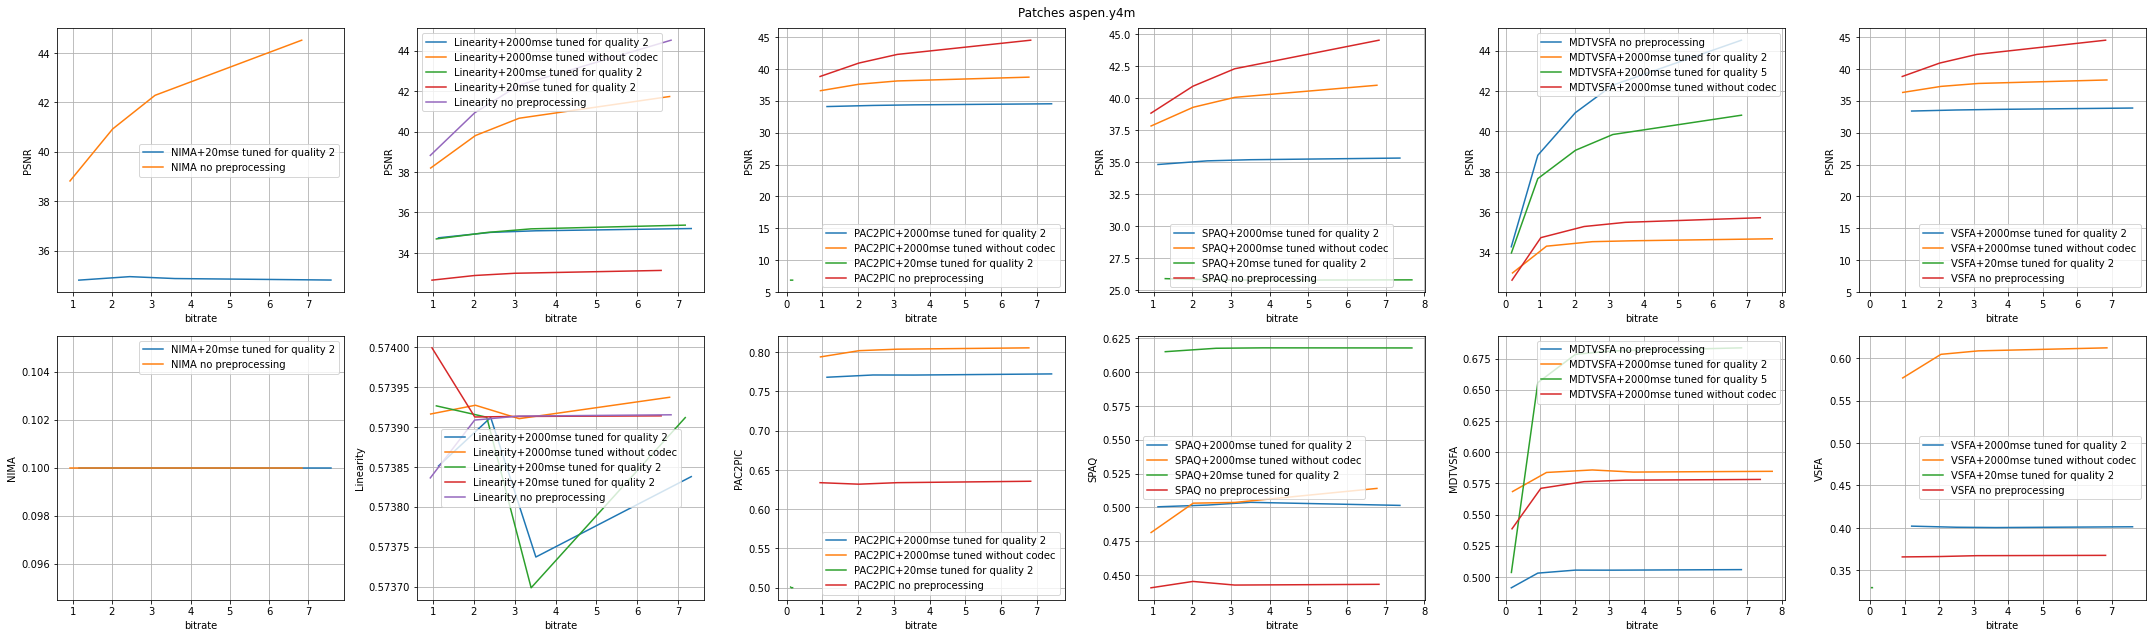

In [102]:

#np.save("./Logs_rd_curves/patches256x256_7videos.npy", Log_1)
Log_loaded1 = np.load("./Logs_rd_curves/patches_pathces_7videos_64frames.npy", allow_pickle=True)
Lst1 = ["vimeo11k_MDTVSFA_2000mse_enhance_cheng2020_attn_quality2.ckpt", 
"./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_cheng2020_no_codec.ckpt",
"./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_cheng2020_attn_quality5.ckpt"]
Log_loaded_Identity = np.load("./Logs_rd_curves/patches_pathces_7videos_64frames_Identity.npy", allow_pickle=True)

Log_loaded1MDTVSFA = np.load("./Logs_rd_curves/patches_7videos_64frames_MDTVSFA.npy", allow_pickle=True)
Log_loaded_Identity_MDTVSFA = np.load("./Logs_rd_curves/patches_7videos_64frames_MDTVSFA_Identity.npy", allow_pickle=True)
force_names_identity = ["Linearity", "NIMA", "PAC2PIC", "SPAQ", "VSFA"]
force_names_all = [i + force_names_identity + ["MDTVSFA"] + p for i,p in zip(get_met_names(), get_met_names(key = "_MDTVSFA_2000mse_enhance"))]
Log_loaded = [list(i[0]) + list(i[1]) +  list(i[2]) + list(i[3]) for i in zip(Log_loaded1, Log_loaded_Identity, Log_loaded_Identity_MDTVSFA, Log_loaded1MDTVSFA)]
#Log_loaded = [list(j) for i,j in zip(Log_loaded1, Log_loaded_Identity)]

#patches
RD_curves_plot(Log_loaded[0], videoname = "Patches " + sorted(os.listdir(dst_dir))[0], save_pgf = False, save_png = False, 
               fig_file = "./vis/RD_curves1/" + sorted(os.listdir(dst_dir))[0], force_names_all= force_names_all)

In [103]:

#np.save("./Logs_rd_curves/patches256x256_7videos.npy", Log_1)
Log_loaded1 = np.load("./Logs_rd_curves/patches_FullHD_7videos_32frames.npy", allow_pickle=True)
Lst1 = ["./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt", 
"./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_no_codec.ckpt",
"./models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_quality5.ckpt"]
Log_loaded_Identity = np.load("./Logs_rd_curves/FullHD_7videos_32frames_Identity.npy", allow_pickle=True)

Log_loaded1MDTVSFA = np.load("./Logs_rd_curves/FullHD_7videos_64frames_MDTVSFA.npy", allow_pickle=True)
Log_loaded_Identity_MDTVSFA = np.load("./Logs_rd_curves/FullHD_7videos_64frames_MDTVSFA_Identity.npy", allow_pickle=True)
force_names_identity = ["Linearity", "NIMA", "PAC2PIC", "SPAQ", "VSFA"]
force_names_all = [i + force_names_identity + ["MDTVSFA"] + p for i,p in zip(get_met_names(), get_met_names(key = "_MDTVSFA_2000mse_enhance"))]
Log_loaded = [list(i[0]) + list(i[1]) +  list(i[2]) + list(i[3]) for i in zip(Log_loaded1, Log_loaded_Identity, Log_loaded_Identity_MDTVSFA, Log_loaded1MDTVSFA)]
#Log_loaded = [list(j) for i,j in zip(Log_loaded1, Log_loaded_Identity)]

#FullHD
RD_curves_plot(Log_loaded[0],videoname = "FullHD " + sorted(os.listdir(dst_dir))[0], save_pgf = False, save_png = False, 
               fig_file = "./vis/RD_curves1/" + sorted(os.listdir(dst_dir))[0], force_names_all= force_names_all)

In [48]:
if save_pgf:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

SyntaxError: unexpected EOF while parsing (<ipython-input-48-dd19c0068a51>, line 8)

In [25]:
Log_1

[[[{'mse_loss': [0.00033656365, 0.006770679, 0.007913411],
    'bpp_loss': [0.34173605, 0.34173605, 0.34173605],
    'loss_classic': [0.5605866, 4.7443695, 5.4874306],
    'Linearity': [-0.57391536, -0.57681936, -0.5738232],
    'loss': [-1147.8303, -1153.632, -1147.6384],
    'bitrate': [1.70545, 2.23155, 3.14735]},
   {'mse_loss': [0.004002055, 0.005578532, 0.00680331],
    'bpp_loss': [0.34173605, 0.34173605, 0.34173605],
    'loss_classic': [2.9440722, 3.9691763, 4.7655883],
    'Linearity': [-0.5739154, -0.5739154, -0.5739154],
    'loss': [-1147.8269, -1147.8252, -1147.824],
    'bitrate': [1.11685, 1.5086, 2.04785]}],
  [{'mse_loss': [0.00016626525, 0.0061087916, 0.0073494557],
    'bpp_loss': [0.34173605, 0.34173605, 0.34173605],
    'loss_classic': [0.44985002, 4.3139772, 5.1207194],
    'Linearity': [-0.57391536, -0.57391536, -0.5738667],
    'loss': [-1147.8306, -1147.8245, -1147.7261],
    'bitrate': [1.0912, 1.47595, 2.04255]},
   {'mse_loss': [0.004002055, 0.005578532, 0.